In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import S_driver_opt_out, S_traveller_opt_out, d2d_kpi_veh, d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns

In [5]:
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.proportional_std = 0.1 # proportional standard deviation [0.1, 0.2, 0.3] for both VoT & RW distributions
params.d2d.ini_att = 0.01
params.d2d.B_income = 1

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in Oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 2 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro 
params.platforms.fare = float(1.2)# float(1.20) #euro/km #http://taxihowmuch.com/
params.platforms.min_fare = float(4) # euro #http://taxihowmuch.com/
params.d2d.fuel_cost = 0.25 #euro/km #https://help.ubercarshare.com/hc/en-gb/articles/360022882131-Choosing-your-car-s-distance-rate  
params.platforms.comm_rate = float(0.20) # float(0.20) for baseline
params.platforms.discount = float(0.0) 
params.platforms.daily_marketing = False
params.platforms.incentive = float(0.0)

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.70
params.d2d.B_WOM = 0.20
params.d2d.B_Marketing = 0.1
params.d2d.diffusion_speed = 10/100 
params.d2d.m = 5 # 5 for hEART
params.d2d.mn = 100/12 # 100/12 for hEART # correlation = 1-(m/mn)
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.f_stop_crit = False
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.fares = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0] # -------------------------
params.random_ini_position = False
params.turnover_interval = 100 #---------------------------------
params.initial_capital = 50000
params.expense_per_day = 500
params.punish_threshold = 5 #----------------------

params.nP = 2000
params.nV = 200
params.nD = 1000
params.simTime = 4
params.d2d.res_wage = params.simTime*11.16

In [ ]:
# sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out, f_trav_out=S_traveller_opt_out,
#                                   kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

sim = MaaSSim.simulators.simulate_Try_and_Select(params=params, f_driver_out=S_driver_opt_out, f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data
09-07-24 14:18:04-WARNING-Setting up 4h simulation at 2024-07-09 12:17:39 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
------------------ P1 TURN ------------------
Day =  0   Middle cell
09-07-24 14:18:14-WARNING-simulation time 4.9 s
np1 =  0   np2 =  0
vp1 =  0   vp2 =  0
Day =  1   Middle cell
09-07-24 14:18:33-WARNING-simulation time 5.0 s
np1 =  15   np2 =  9
vp1 =  2   vp2 =  3
Day =  2   Middle cell
09-07-24 14:18:43-WARNING-simulation time 4.4 s
np1 =  36   np2 =  32
vp1 =  2   vp2 =  3
Day =  3   Middle cell
09-07-24 14:18:57-WARNING-simulation time 5.8 s
np1 =  54   np2 =  52
vp1 =  0   vp2 =  7
Day =  4   Middle cell
09-07-24 14:19:12-WARNING-simulation time 7.0 s
np1 =  71   np2 =  63
vp1 =  8   vp2 =  6
Day =  5   Middle cell


In [27]:
sim.res[d].pax_exp.OUT.value_counts()[False]

623

<AxesSubplot:>

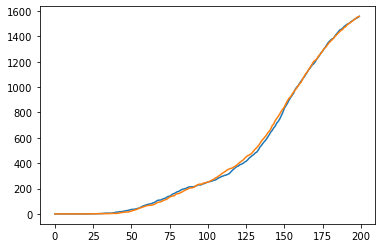

In [7]:
p1 = []; p2 = []; day = []

for i in range(200):
    df = sim.res[i].pax_exp
    day.append(i)
    p1.append(len(df[df.P1_hate>5]))
    p2.append(len(df[df.P2_hate>5]))
    
sns.lineplot(x=day, y=p1)
sns.lineplot(x=day, y=p2)

In [63]:
df = sim.res[250].pax_exp
len(df[df.P1_hate>7])

486

In [15]:
0%5

0

In [8]:
params.nD = len(sim.res)

df_s = pd.DataFrame()
df_d = pd.DataFrame()

for d in range(0,params.nD):
    
    pax_exp = sim.res[d].pax_exp
    veh_exp = sim.res[d].veh_exp
    platforms = sim.res[d].platforms
    
    df_d.at[d, 'P1_EXPERIENCE_U'] = pax_exp.P1_EXPERIENCE_U.mean()
    df_d.at[d, 'P2_EXPERIENCE_U'] = pax_exp.P2_EXPERIENCE_U.mean()
    df_d.at[d, 'P1_WOM_U'] = pax_exp.P1_WOM_U.mean()
    df_d.at[d, 'P2_WOM_U'] = pax_exp.P2_WOM_U.mean()
    df_d.at[d, 'P1_MARKETING_U'] = pax_exp.P1_MARKETING_U.mean()
    df_d.at[d, 'P2_MARKETING_U'] = pax_exp.P2_MARKETING_U.mean()
    df_d.at[d, 'P1_OUT'] = pax_exp[pax_exp.platform_id==1].OUT.value_counts().get(False, 0)
    df_d.at[d, 'P2_OUT'] = pax_exp[pax_exp.platform_id==2].OUT.value_counts().get(False, 0)
    df_d.at[d, 'P1_ACTUAL_WT'] = pax_exp[pax_exp.platform_id==1].ACTUAL_WT.mean()
    df_d.at[d, 'P2_ACTUAL_WT'] = pax_exp[pax_exp.platform_id==2].ACTUAL_WT.mean()
    df_d.at[d, 'P1_MATCHING_T'] = pax_exp[pax_exp.platform_id==1].MATCHING_T.mean()
    df_d.at[d, 'P2_MATCHING_T'] = pax_exp[pax_exp.platform_id==2].MATCHING_T.mean()
    df_d.at[d, 'P1_PICKUP_T'] = veh_exp[veh_exp.platform_id==1].ARRIVES_AT_PICKUP.mean()/(veh_exp[veh_exp.platform_id==1].nRIDES.mean()*60)
    df_d.at[d, 'P2_PICKUP_T'] = veh_exp[veh_exp.platform_id==2].ARRIVES_AT_PICKUP.mean()/(veh_exp[veh_exp.platform_id==2].nRIDES.mean()*60)
    df_d.at[d, 'PICKUP_T'] = veh_exp[veh_exp.OUT==False].ARRIVES_AT_PICKUP.mean()/(veh_exp[veh_exp.OUT==False].nRIDES.mean()*60)
    df_d.at[d, 'P1_plat_revenue'] = pax_exp[pax_exp.platform_id==1].plat_revenue.sum()
    df_d.at[d, 'P2_plat_revenue'] = pax_exp[pax_exp.platform_id==2].plat_revenue.sum()
    
    df_d.at[d, 'P1_daily_profit'] = platforms.P_daily_profit.loc[1]
    df_d.at[d, 'P2_daily_profit'] = platforms.P_daily_profit.loc[2]
    df_d.at[d, 'P1_remaining_capital'] = platforms.P_remaining_capital.loc[1]
    df_d.at[d, 'P2_remaining_capital'] = platforms.P_remaining_capital.loc[2]
    
    df_s.at[d, 'P1_EXPERIENCE_U'] = veh_exp.P1_EXPERIENCE_U.mean()
    df_s.at[d, 'P2_EXPERIENCE_U'] = veh_exp.P2_EXPERIENCE_U.mean()
    df_s.at[d, 'P1_WOM_U'] = veh_exp.P1_WOM_U.mean()
    df_s.at[d, 'P2_WOM_U'] = veh_exp.P2_WOM_U.mean()
    df_s.at[d, 'P1_MARKETING_U'] = veh_exp.P1_MARKETING_U.mean()
    df_s.at[d, 'P2_MARKETING_U'] = veh_exp.P2_MARKETING_U.mean()
    df_s.at[d, 'P1_OUT'] = veh_exp[veh_exp.platform_id==1].OUT.value_counts().get(False, 0)
    df_s.at[d, 'P2_OUT'] = veh_exp[veh_exp.platform_id==2].OUT.value_counts().get(False, 0)
    df_s.at[d, 'P1_IDLE_TIME'] = veh_exp[veh_exp.platform_id==1].IDLE_TIME.mean()/60
    df_s.at[d, 'P2_IDLE_TIME'] = veh_exp[veh_exp.platform_id==2].IDLE_TIME.mean()/60
    df_s.at[d, 'P1_REVENUE'] = veh_exp[veh_exp.platform_id==1].REVENUE.mean()
    df_s.at[d, 'P2_REVENUE'] = veh_exp[veh_exp.platform_id==2].REVENUE.mean()
    df_s.at[d, 'P1_ACTUAL_INC'] = veh_exp[veh_exp.platform_id==1].ACTUAL_INC.mean()
    df_s.at[d, 'P2_ACTUAL_INC'] = veh_exp[veh_exp.platform_id==2].ACTUAL_INC.mean()
    df_s.at[d, 'P1_COST'] = veh_exp[veh_exp.platform_id==1].COST.mean()
    df_s.at[d, 'P2_COST'] = veh_exp[veh_exp.platform_id==2].COST.mean()
    
    if d==0: d_cols = df_d.columns.values.tolist()
    if d==0: s_cols = df_s.columns.values.tolist()
    
    ld = sim.res[0].pax_exp.columns.values.tolist()
    ldn = [i for i in ld if i not in d_cols]
    for col in ldn:
        df_d.at[d, col] = pax_exp[pax_exp.OUT==False][col].mean()
        
    ls = sim.res[0].veh_exp.columns.values.tolist()
    lsn = [i for i in ls if i not in s_cols]
    for col in lsn:
        df_s.at[d, col] = veh_exp[veh_exp.OUT==False][col].mean()
        
# run_id = 'traj_p1_1.0_p2_1.0_500_50000'
# df_d.to_csv('competition_csv/demand_{}.csv'.format(run_id))
# df_s.to_csv('competition_csv/supply_{}.csv'.format(run_id))

In [9]:
def smooth(y,w=7,o=1,d=5):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

<AxesSubplot:ylabel='P1_OUT'>

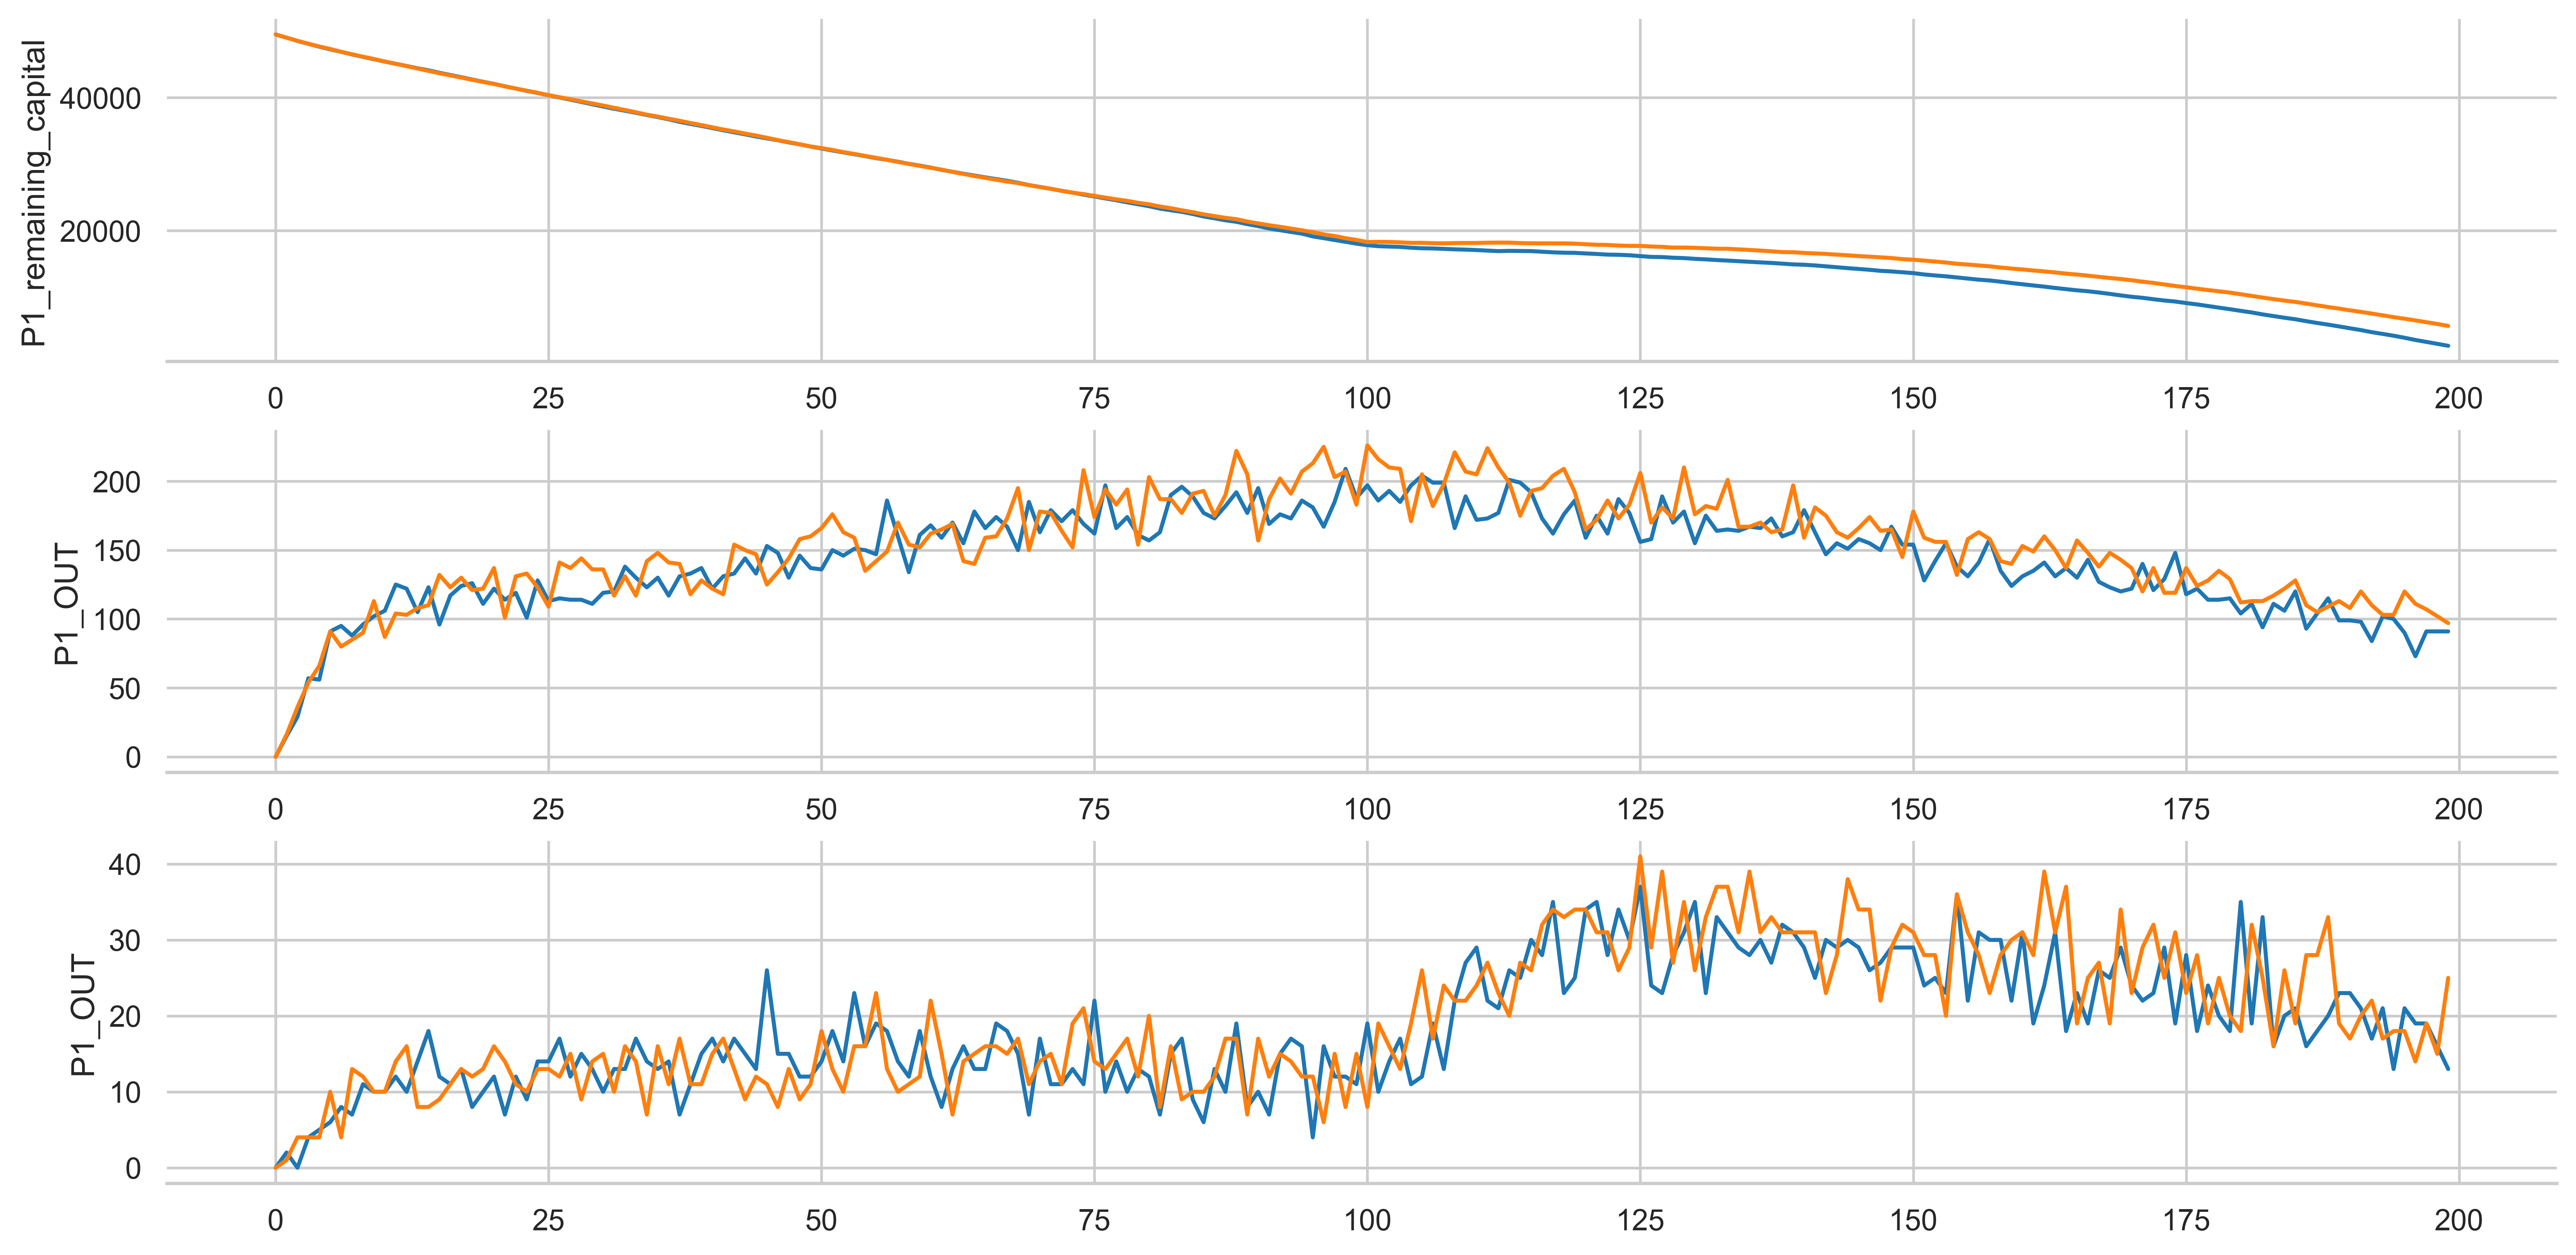

In [10]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=3, figsize=(16,8))
sns.despine(left=True)

sns.lineplot(x=df_d.index, y=df_d.P1_remaining_capital, ax=ax[0])
sns.lineplot(x=df_d.index, y=df_d.P2_remaining_capital, ax=ax[0])

sns.lineplot(x=df_d.index, y=df_d.P1_OUT, ax=ax[1])
sns.lineplot(x=df_d.index, y=df_d.P2_OUT, ax=ax[1])

sns.lineplot(x=df_s.index, y=df_s.P1_OUT, ax=ax[2])
sns.lineplot(x=df_s.index, y=df_s.P2_OUT, ax=ax[2])

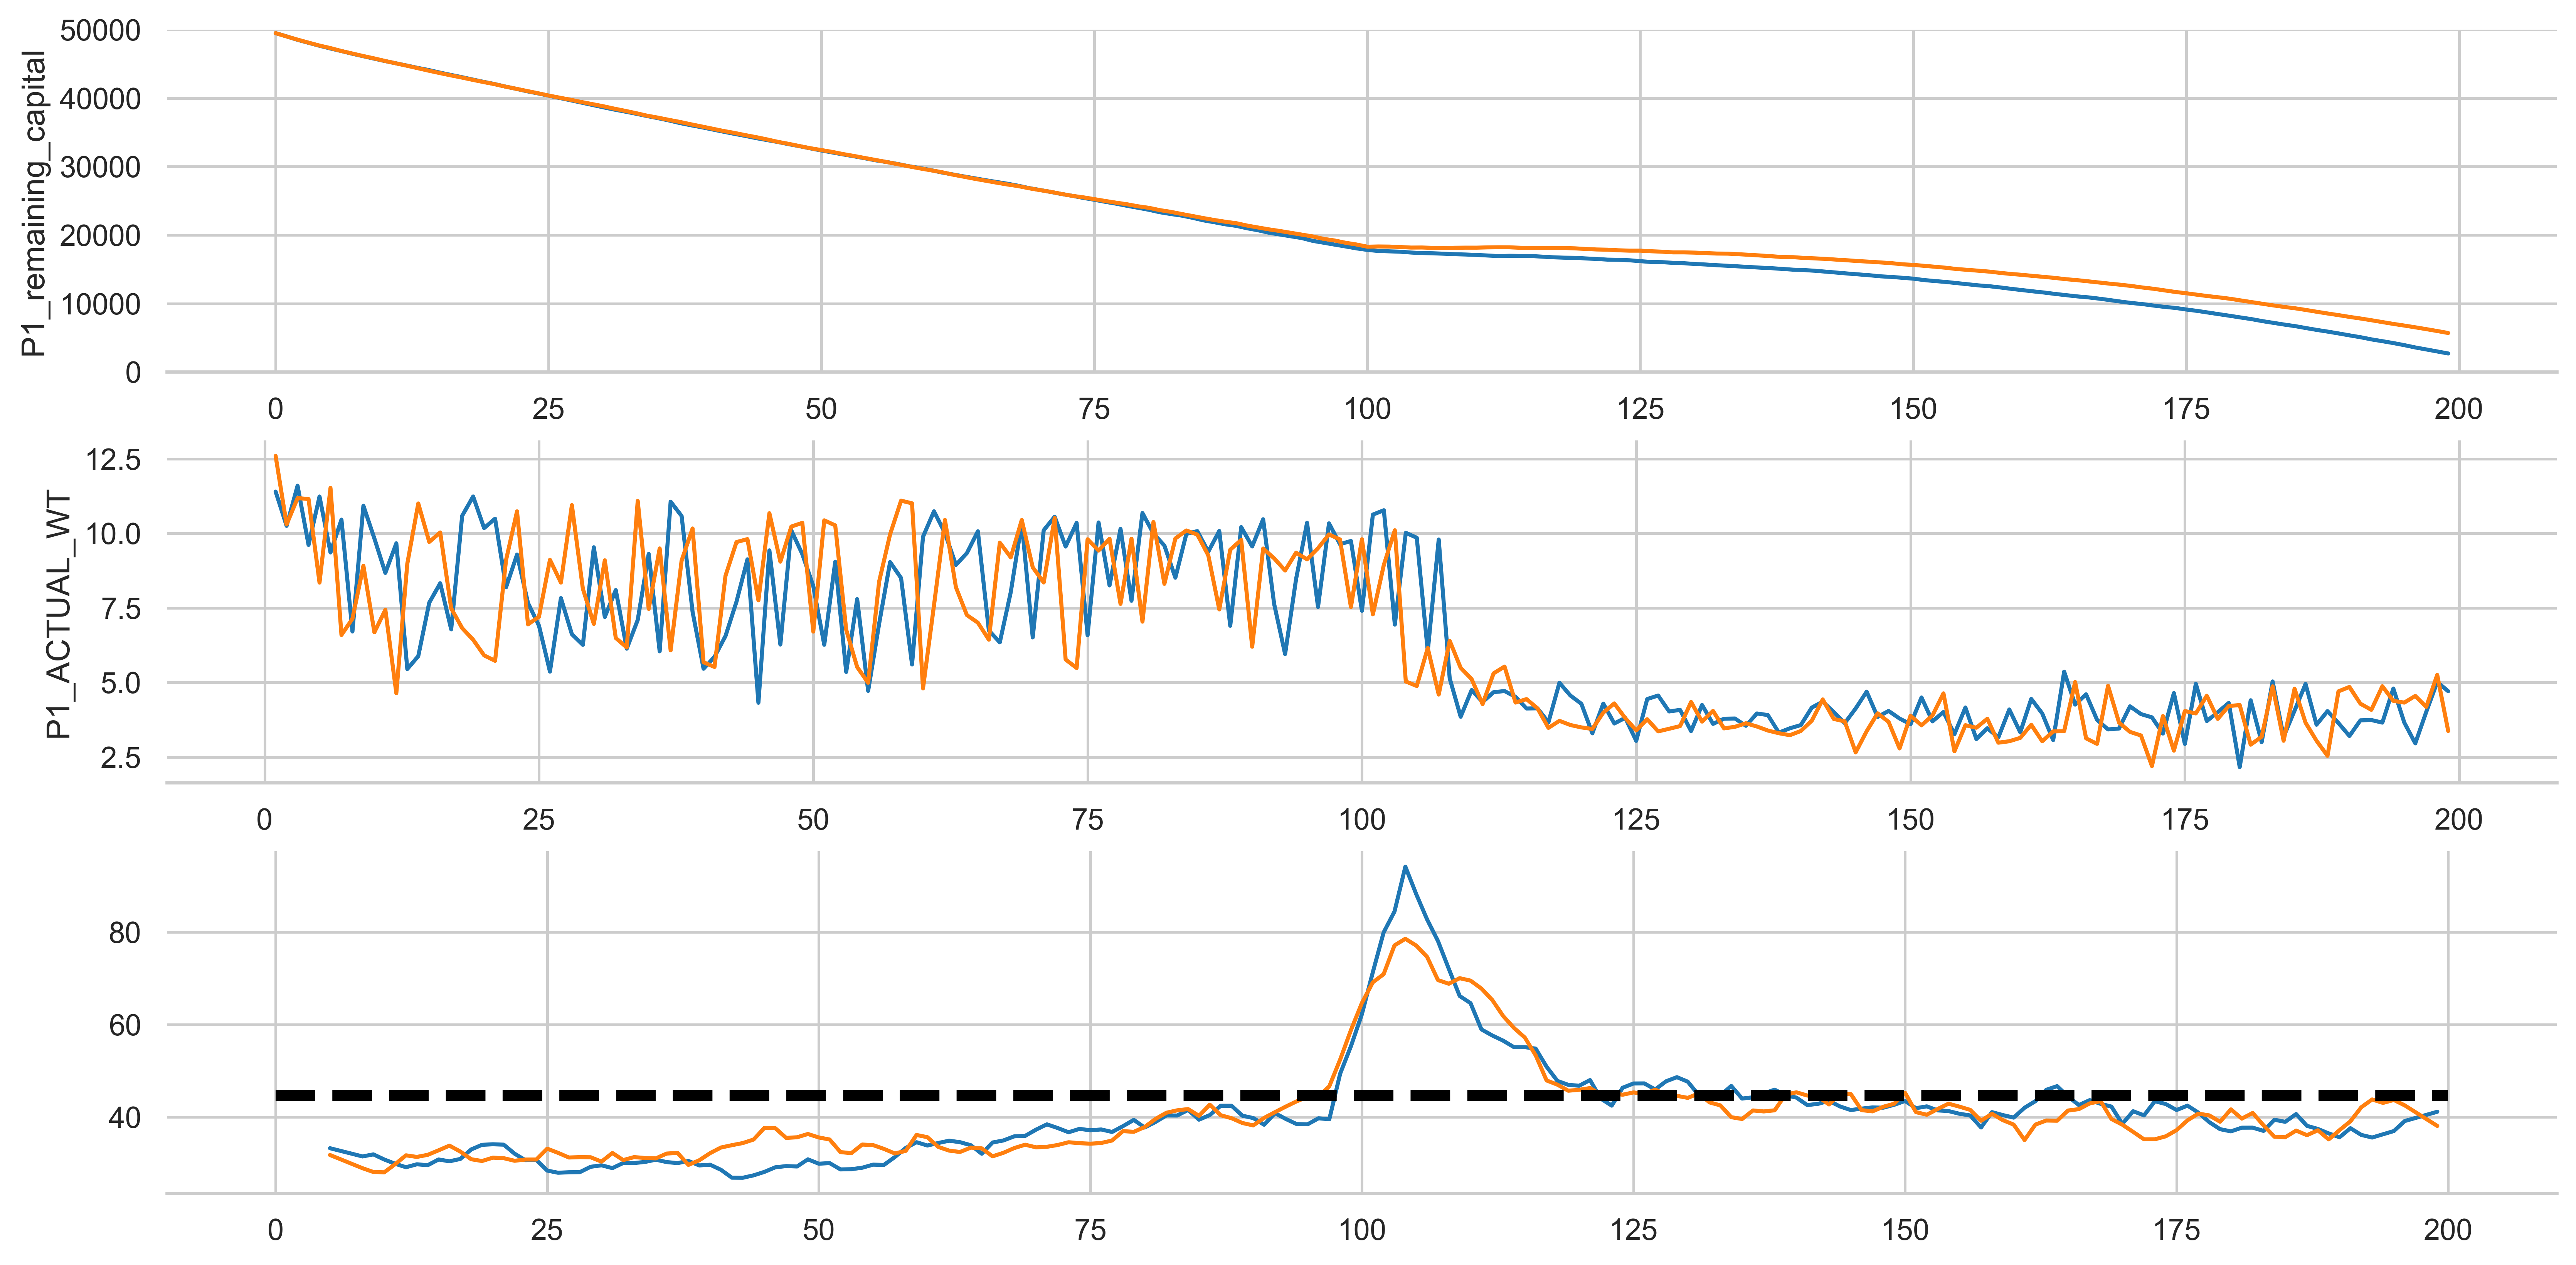

In [14]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=3, figsize=(16,8))
sns.despine(left=True)

sns.lineplot(x=df_d.index, y=df_d.P1_remaining_capital, ax=ax[0])
sns.lineplot(x=df_d.index, y=df_d.P2_remaining_capital, ax=ax[0])

ax[0].set(ylim=[0,50000])

sns.lineplot(x=df_d.index, y=df_d.P1_ACTUAL_WT, ax=ax[1])
sns.lineplot(x=df_d.index, y=df_d.P2_ACTUAL_WT, ax=ax[1])

sns.lineplot(x=df_s.index, y=smooth(df_s.P1_ACTUAL_INC), ax=ax[2])
sns.lineplot(x=df_s.index, y=smooth(df_s.P2_ACTUAL_INC), ax=ax[2])
ax[2].hlines([params.d2d.res_wage], 0, params.nD, linestyles='dashed', colors='black', lw=4, zorder=10)

<AxesSubplot:ylabel='P1_EXPERIENCE_U'>

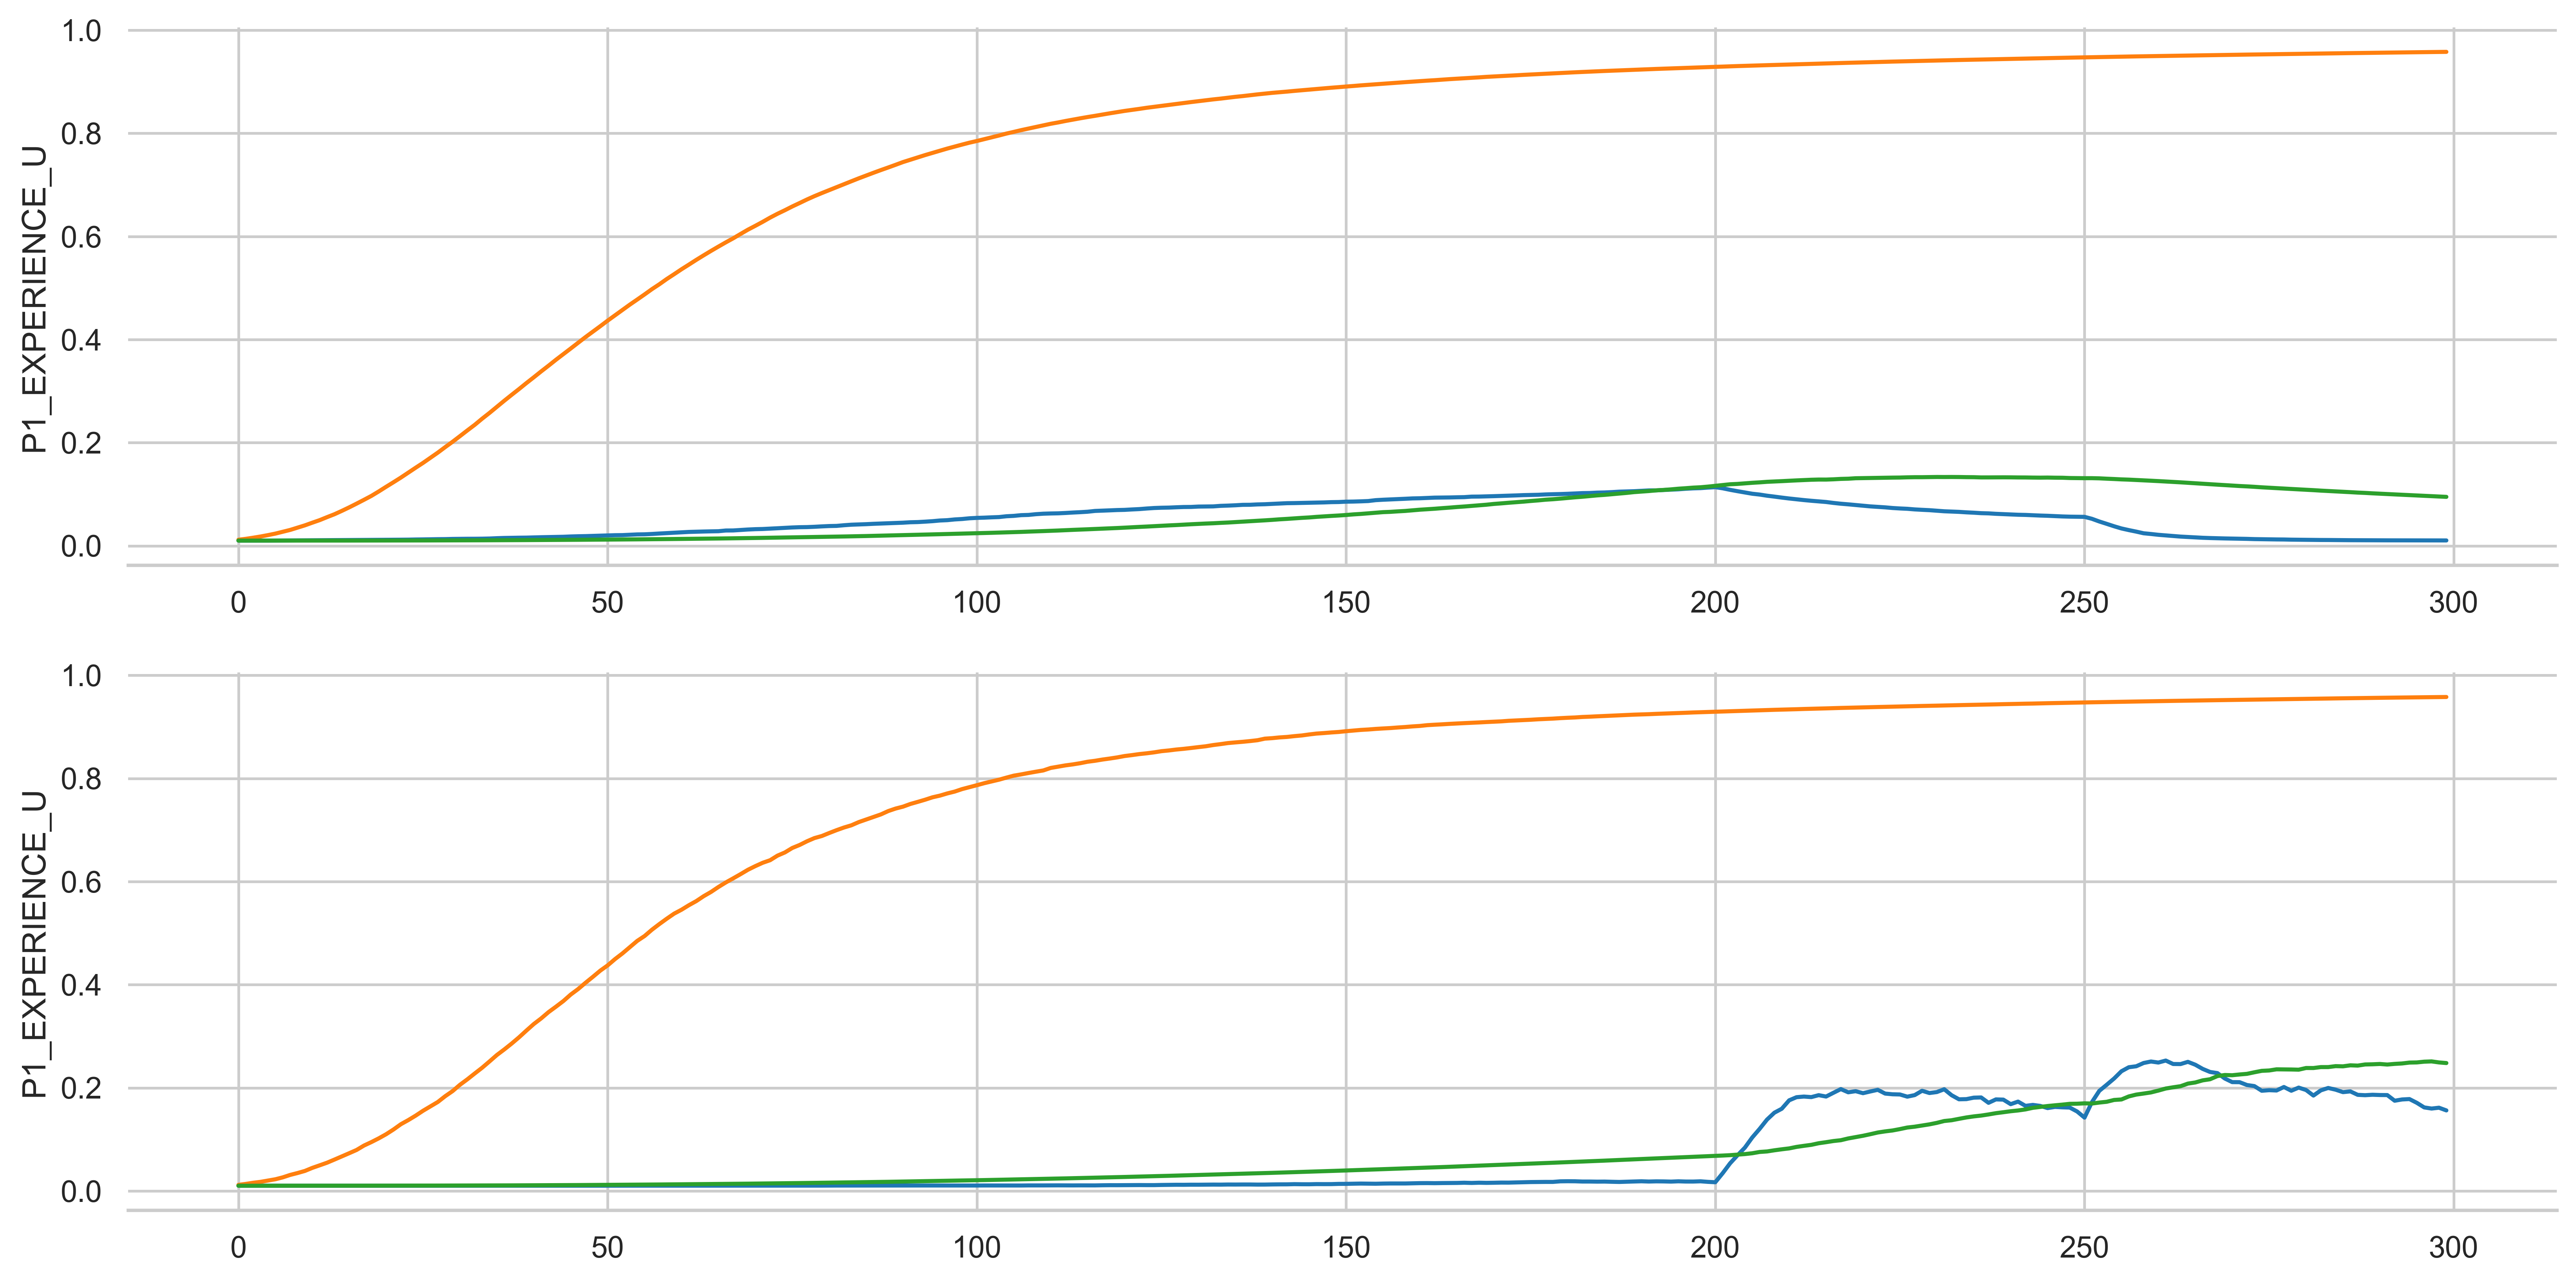

In [15]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
sns.despine(left=True)

sns.lineplot(x=df_d.index, y=df_d.P1_EXPERIENCE_U, ax=ax[0])
sns.lineplot(x=df_d.index, y=df_d.P1_MARKETING_U, ax=ax[0])
sns.lineplot(x=df_d.index, y=df_d.P1_WOM_U, ax=ax[0])

sns.lineplot(x=df_s.index, y=df_s.P1_EXPERIENCE_U, ax=ax[1])
sns.lineplot(x=df_s.index, y=df_s.P1_MARKETING_U, ax=ax[1])
sns.lineplot(x=df_s.index, y=df_s.P1_WOM_U, ax=ax[1])

<AxesSubplot:ylabel='P2_EXPERIENCE_U'>

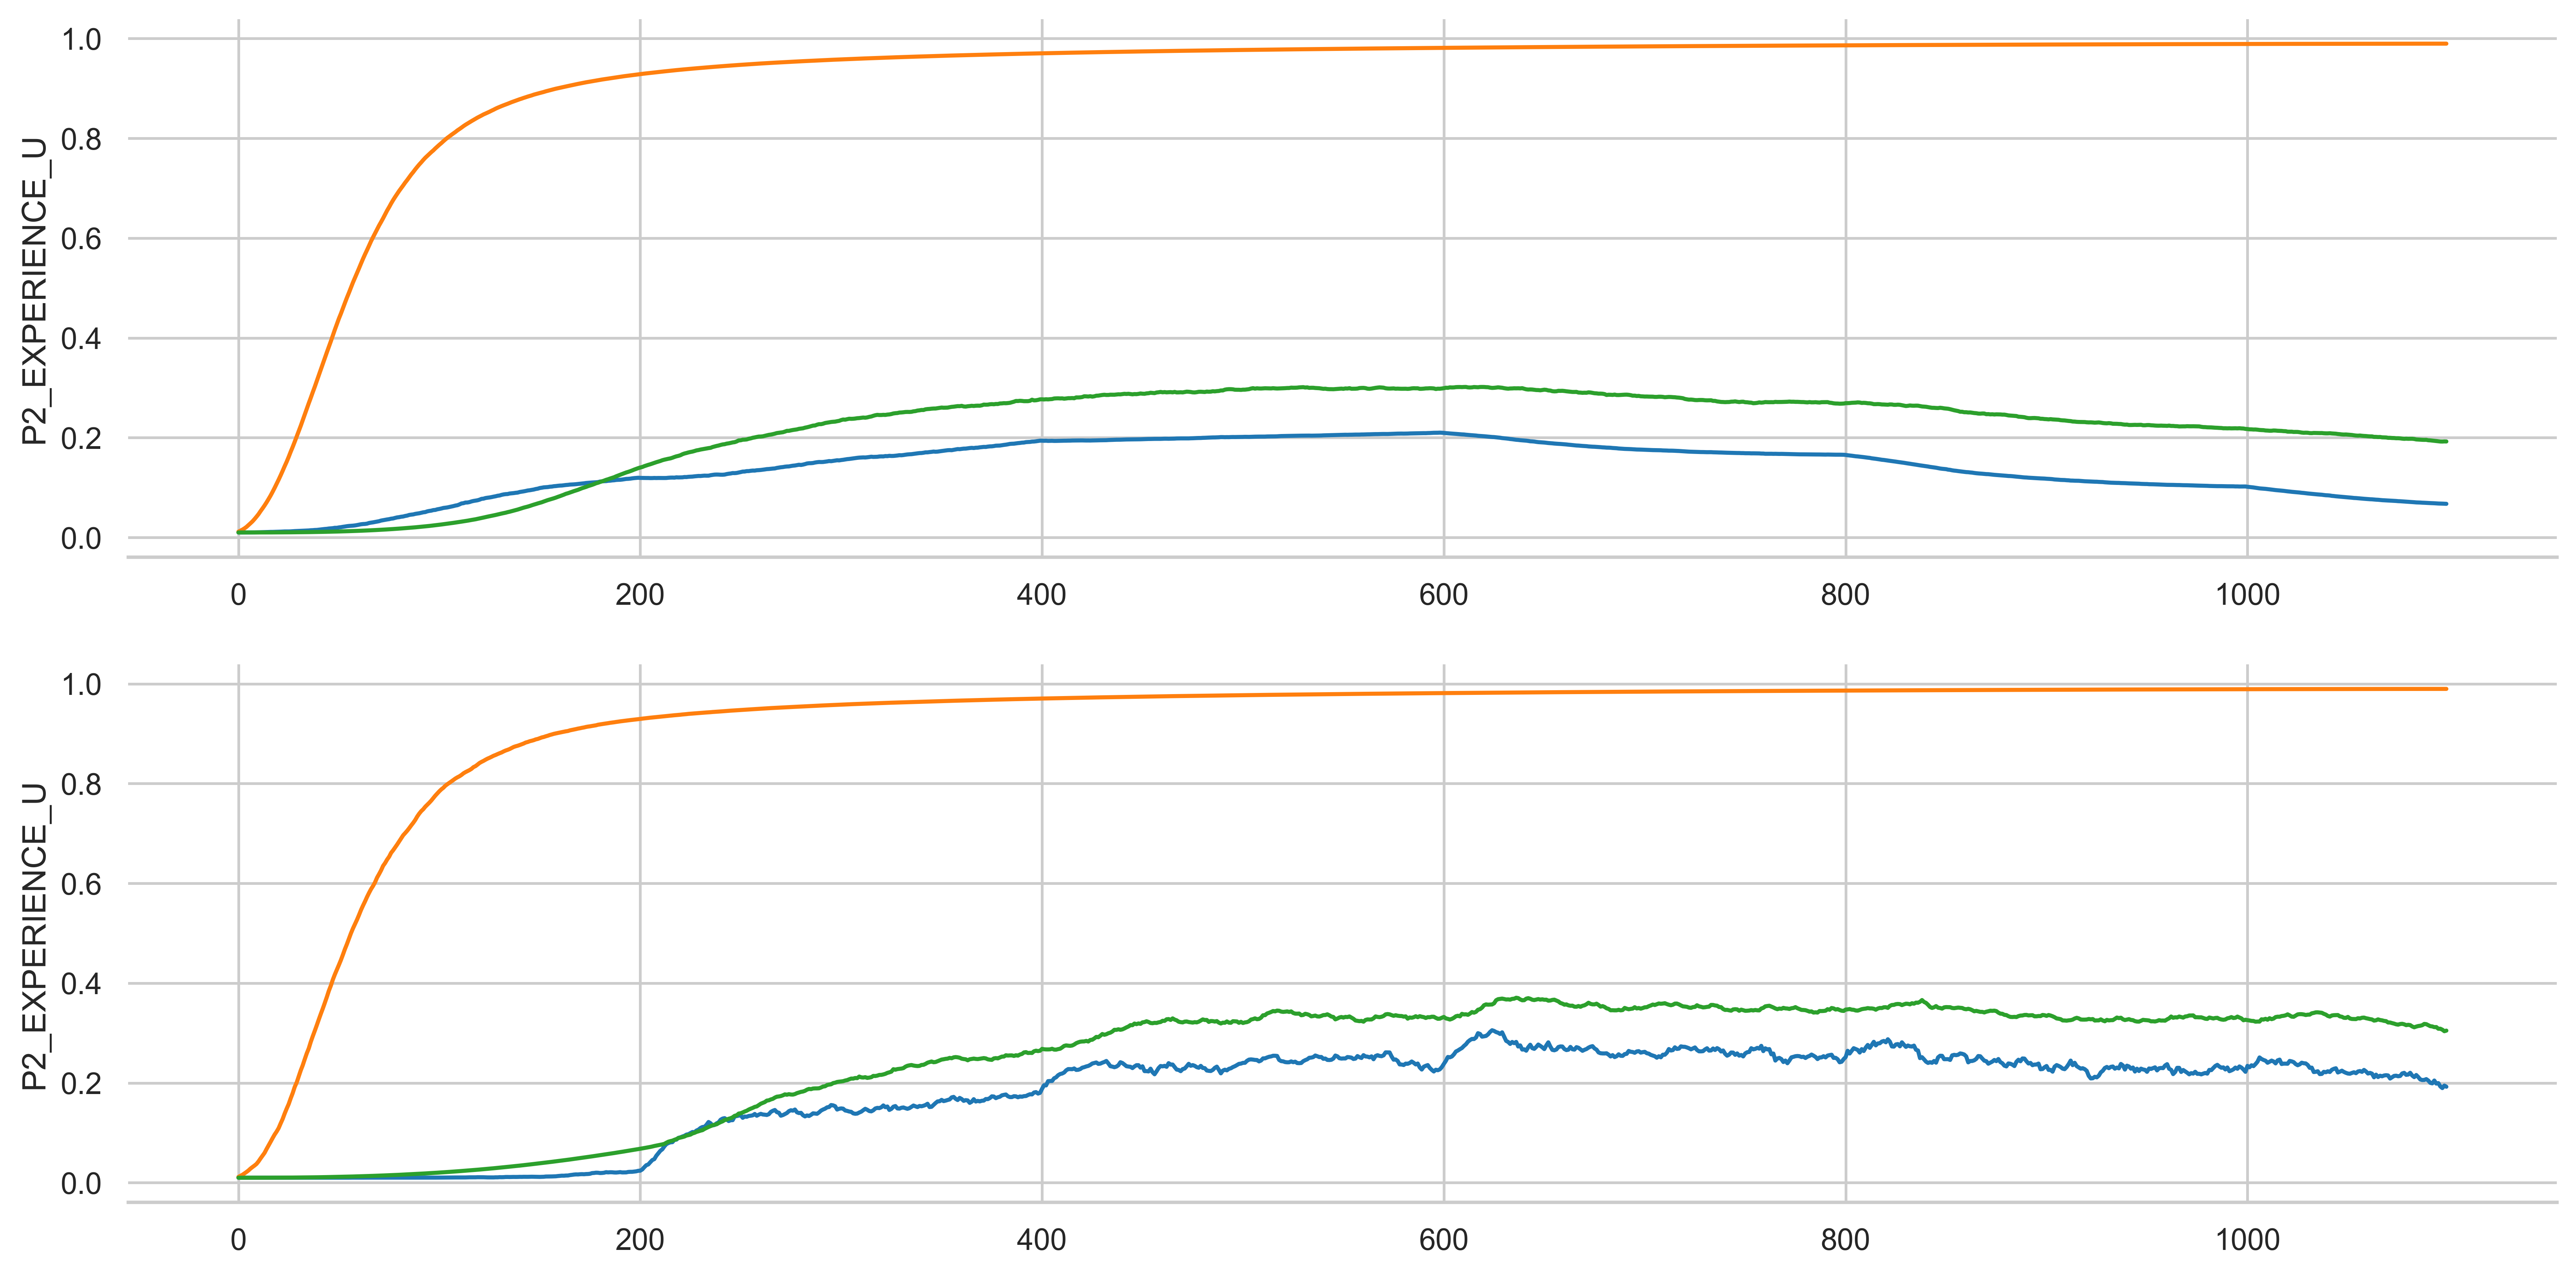

In [118]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
sns.despine(left=True)

sns.lineplot(x=df_d.index, y=df_d.P2_EXPERIENCE_U, ax=ax[0])
sns.lineplot(x=df_d.index, y=df_d.P2_MARKETING_U, ax=ax[0])
sns.lineplot(x=df_d.index, y=df_d.P2_WOM_U, ax=ax[0])

sns.lineplot(x=df_s.index, y=df_s.P2_EXPERIENCE_U, ax=ax[1])
sns.lineplot(x=df_s.index, y=df_s.P2_MARKETING_U, ax=ax[1])
sns.lineplot(x=df_s.index, y=df_s.P2_WOM_U, ax=ax[1])

In [285]:
df = sim.res[0].pax_exp
# df = df[df.OUT==False]
df

P_U       PT_U  ACTUAL_WT  U_dif   OUT   mu   wu  nDAYS_HAILED  \
pax                                                                          
0     -5.680417 -10.056447        0.0    0.0  True  0.0  0.0           0.0   
1     -9.430722 -14.028102        0.0    0.0  True  0.0  0.0           0.0   
2     -9.965786 -15.211582        0.0    0.0  True  0.0  0.0           0.0   
3     -5.546889  -5.318101        0.0    0.0  True  0.0  0.0           0.0   
4    -14.659692 -15.421325        0.0    0.0  True  0.0  0.0           0.0   
...         ...        ...        ...    ...   ...  ...  ...           ...   
1995  -8.527028 -11.227600        0.0    0.0  True  0.0  0.0           0.0   
1996  -5.735228  -8.859496        0.0    0.0  True  0.0  0.0           0.0   
1997  -7.000600 -10.274451        0.0    0.0  True  0.0  0.0           0.0   
1998  -6.693733 -10.708116        0.0    0.0  True  0.0  0.0           0.0   
1999  -5.430314  -9.609012        0.0    0.0  True  0.0  0.0           0.0   

      nDAYS_TRY  P1_EXPERIENCE_U  ...  ACCEPTS_OFFER  REJECTS_OFFER  \
pax                               ...                                 
0           0.0             0.01  ...            0.0            0.0   
1           0.0             0.01  ...            0.0            0.0   
2           0.0             0.01  ...            0.0            0.0   
3           0.0             0.01  ...            0.0            0.0   
4           0.0             0.01  ...            0.0            0.0   
...         ...              ...  ...            ...            ...   
1995        0.0             0.01  ...            0.0            0.0   
1996        0.0             0.01  ...            0.0            0.0   
1997        0.0             0.01  ...            0.0            0.0   
1998        0.0             0.01  ...            0.0            0.0   
1999        0.0             0.01  ...            0.0            0.0   

      ARRIVES_AT_PICKUP  MEETS_DRIVER_AT_PICKUP  DEPARTS_FROM_PICKUP  \
pax                                                                    
0                   0.0                     0.0                  0.0   
1                   0.0                     0.0                  0.0   
2                   0.0                     0.0                  0.0   
3                   0.0                     0.0                  0.0   
4                   0.0                     0.0                  0.0   
...                 ...                     ...                  ...   
1995                0.0                     0.0                  0.0   
1996                0.0                     0.0                  0.0   
1997                0.0                     0.0                  0.0   
1998                0.0                     0.0                  0.0   
1999                0.0                     0.0                  0.0   

     ARRIVES_AT_DROPOFF SETS_OFF_FOR_DEST  ARRIVES_AT_DEST  \
pax                                                          
0                   0.0               0.0              0.0   
1                   0.0               0.0              0.0   
2                   0.0               0.0              0.0   
3                   0.0               0.0              0.0   
4                   0.0               0.0              0.0   
...                 ...               ...              ...   
1995                0.0               0.0              0.0   
1996                0.0               0.0              0.0   
1997                0.0               0.0              0.0   
1998                0.0               0.0              0.0   
1999                0.0               0.0              0.0   

      PREFERS_OTHER_SERVICE  LOSES_PATIENCE  
pax                                          
0                       0.0             0.0  
1                       0.0             0.0  
2                       0.0             0.0  
3                       0.0             0.0  
4                       0.0             0.0  
...    

In [286]:
df[df.P1_EXPERIENCE_U==0.01]

P_U       PT_U  ACTUAL_WT  U_dif   OUT   mu   wu  nDAYS_HAILED  \
pax                                                                          
0     -5.680417 -10.056447        0.0    0.0  True  0.0  0.0           0.0   
1     -9.430722 -14.028102        0.0    0.0  True  0.0  0.0           0.0   
2     -9.965786 -15.211582        0.0    0.0  True  0.0  0.0           0.0   
3     -5.546889  -5.318101        0.0    0.0  True  0.0  0.0           0.0   
4    -14.659692 -15.421325        0.0    0.0  True  0.0  0.0           0.0   
...         ...        ...        ...    ...   ...  ...  ...           ...   
1995  -8.527028 -11.227600        0.0    0.0  True  0.0  0.0           0.0   
1996  -5.735228  -8.859496        0.0    0.0  True  0.0  0.0           0.0   
1997  -7.000600 -10.274451        0.0    0.0  True  0.0  0.0           0.0   
1998  -6.693733 -10.708116        0.0    0.0  True  0.0  0.0           0.0   
1999  -5.430314  -9.609012        0.0    0.0  True  0.0  0.0           0.0   

      nDAYS_TRY  P1_EXPERIENCE_U  ...  ACCEPTS_OFFER  REJECTS_OFFER  \
pax                               ...                                 
0           0.0             0.01  ...            0.0            0.0   
1           0.0             0.01  ...            0.0            0.0   
2           0.0             0.01  ...            0.0            0.0   
3           0.0             0.01  ...            0.0            0.0   
4           0.0             0.01  ...            0.0            0.0   
...         ...              ...  ...            ...            ...   
1995        0.0             0.01  ...            0.0            0.0   
1996        0.0             0.01  ...            0.0            0.0   
1997        0.0             0.01  ...            0.0            0.0   
1998        0.0             0.01  ...            0.0            0.0   
1999        0.0             0.01  ...            0.0            0.0   

      ARRIVES_AT_PICKUP  MEETS_DRIVER_AT_PICKUP  DEPARTS_FROM_PICKUP  \
pax                                                                    
0                   0.0                     0.0                  0.0   
1                   0.0                     0.0                  0.0   
2                   0.0                     0.0                  0.0   
3                   0.0                     0.0                  0.0   
4                   0.0                     0.0                  0.0   
...                 ...                     ...                  ...   
1995                0.0                     0.0                  0.0   
1996                0.0                     0.0                  0.0   
1997                0.0                     0.0                  0.0   
1998                0.0                     0.0                  0.0   
1999                0.0                     0.0                  0.0   

     ARRIVES_AT_DROPOFF SETS_OFF_FOR_DEST  ARRIVES_AT_DEST  \
pax                                                          
0                   0.0               0.0              0.0   
1                   0.0               0.0              0.0   
2                   0.0               0.0              0.0   
3                   0.0               0.0              0.0   
4                   0.0               0.0              0.0   
...                 ...               ...              ...   
1995                0.0               0.0              0.0   
1996                0.0               0.0              0.0   
1997                0.0               0.0              0.0   
1998                0.0               0.0              0.0   
1999                0.0               0.0              0.0   

      PREFERS_OTHER_SERVICE  LOSES_PATIENCE  
pax                                          
0                       0.0             0.0  
1                       0.0             0.0  
2                       0.0             0.0  
3                       0.0             0.0  
4                       0.0             0.0  
...    

In [239]:
d = 1099

params.d2d.B_Experience = 0.7
params.d2d.B_Marketing = 0.1

u_pt = 0.5
P1_U = params.d2d.B_Experience*df_d.P1_EXPERIENCE_U[d] + params.d2d.B_Marketing*df_d.P1_MARKETING_U[d] + params.d2d.B_WOM*df_d.P1_WOM_U[d]
P2_U = params.d2d.B_Experience*df_d.P2_EXPERIENCE_U[d] + params.d2d.B_Marketing*df_d.P2_MARKETING_U[d] + params.d2d.B_WOM*df_d.P2_WOM_U[d]

print(round(P1_U, 2), round(P2_U,2))

0.19 0.18


In [240]:
P1_U = 0.0
P2_U = 0.0

In [241]:
from numpy import log as ln

params.d2d.mn = 100/8# 5#100/20
params.d2d.m = 7

print(1-(params.d2d.m/params.d2d.mn))

alts_u = {'RW': 0.5, 'plats':{'P1': 'Nan', 'P2': 'Nan'}}
alts_x = {'RW': 'Nan', 'P1': 'Nan', 'P2': 'Nan', 'plats':{'P1': 'Nan', 'P2': 'Nan'}}
alts_p = {'RW': 'Nan', 'plats':{'P1': 'Nan', 'P2': 'Nan'}}

alts_u = {'RW': 0.5, 'plats':{'P1': round(P1_U,2), 'P2': round(P2_U,2)}}

for p in alts_u['plats']: # calculate X in platform nest
    alts_x['plats'][p] = math.exp(params.d2d.mn*alts_u['plats'][p]) if alts_u['plats'][p]!= 'Nan' else 0

w = (1/params.d2d.mn)*ln(sum(alts_x['plats'].values()))    # RH satisfaction - Logsum
for p in alts_u['plats']: # calculate probability in platform nest
    alts_p['plats'][p] = alts_x['plats'][p]/sum(alts_x['plats'].values())
    alts_u[p] = w if alts_u['plats'][p]!= 'Nan' else 'Nan'
    
alts_x.pop('plats', None)
for alt in alts_x:
    alts_x[alt] = math.exp(params.d2d.m*alts_u[alt]) if alts_u[alt]!= 'Nan' else 0

x_w = math.exp(params.d2d.m*w)
for alt in alts_x:
    alts_p[alt] = (alts_x[alt]/(alts_x['RW'] + x_w))*alts_p['plats'][alt] if alt!='RW' else alts_x[alt]/(alts_x['RW'] + x_w)

print('P2 = ', alts_p['P1'])
print('P1 = ', alts_p['P2'])



0.43999999999999995
P2 =  0.021310799381562037
P1 =  0.021310799381562037


In [215]:
print('P1 = ', df_d.P1_OUT[d]/2000)
print('P2 = ', df_d.P2_OUT[d]/2000)

P1 =  0.134
P2 =  0.1295


In [113]:
d = 999

sim.res[d].pax_exp.wu.value_counts()[1] - sim.res[d].pax_exp.mu.value_counts()[1]

0

In [97]:
d = 599
df = sim.res[d].pax_exp
df.OUT.value_counts()[False]

527

In [98]:
df = df[df.OUT==False]
df[df.P_U>df.PT_U]

P_U       PT_U  ACTUAL_WT     U_dif    OUT   mu   wu  \
pax                                                                
0     -9.600594 -10.056447   1.733333 -0.045329  False  1.0  1.0   
22   -11.186800 -11.758797   1.433333 -0.048644  False  1.0  1.0   
33   -10.163058 -11.106069   1.200000 -0.084909  False  1.0  1.0   
50    -8.843386  -9.720716   0.466667 -0.090254  False  1.0  1.0   
54    -9.790672 -10.717607   1.233333 -0.086487  False  1.0  1.0   
...         ...        ...        ...       ...    ...  ...  ...   
1825  -9.884244 -10.820355   0.066667 -0.086514  False  1.0  1.0   
1829  -8.907772 -10.100603   0.566667 -0.118095  False  1.0  1.0   
1843 -11.932853 -12.082107   0.100000 -0.012353  False  1.0  1.0   
1890 -10.394978 -10.857091   3.750000 -0.042563  False  1.0  1.0   
1954 -11.103700 -11.216770   2.500000 -0.010080  False  1.0  1.0   

      nDAYS_HAILED  nDAYS_TRY  P1_EXPERIENCE_U  ...  ACCEPTS_OFFER  \
pax                                             ...                  
0            810.0      817.0         0.042835  ...           15.0   
22           882.0      887.0         0.990000  ...           15.0   
33           894.0      897.0         0.990000  ...           15.0   
50           729.0      735.0         0.976876  ...           15.0   
54           849.0      861.0         0.990000  ...           15.0   
...            ...        ...              ...  ...            ...   
1825         844.0      854.0         0.051333  ...           15.0   
1829         781.0      793.0         0.990000  ...           15.0   
1843         868.0      873.0         0.972421  ...           15.0   
1890         844.0      849.0         0.990000  ...           15.0   
1954         795.0      807.0         0.037660  ...           15.0   

      REJECTS_OFFER  ARRIVES_AT_PICKUP  MEETS_DRIVER_AT_PICKUP  \
pax                                                              
0               0.0               20.0                   104.0   
22              0.0               20.0                    86.0   
33              0.0               20.0                    72.0   
50              0.0               20.0                    28.0   
54              0.0               20.0                    74.0   
...             ...                ...                     ...   
1825            0.0               20.0                     4.0   
1829            0.0               20.0                    34.0   
1843            0.0               20.0                     6.0   
1890            0.0               20.0                   225.0   
1954            0.0               20.0                   150.0   

      DEPARTS_FROM_PICKUP ARRIVES_AT_DROPOFF SETS_OFF_FOR_DEST  \
pax                                                              
0                    30.0              330.0              10.0   
22                   30.0              404.0              10.0   
33                   30.0              363.0              10.0   
50                   30.0              317.0              10.0   
54                   30.0              346.0              10.0   
...                   ...                ...               ...   
1825                 30.0              368.0              10.0   
1829                 30.0              318.0              10.0   
1843                 30.0              457.0              10.0   
1890                 30.0              334.0              10.0   
1954                 30.0              384.0              10.0   

      ARRIVES_AT_DEST  PREFERS_OTHER_SERVICE  LOSES_PATIENCE  
pax                                                           
0                 0.0                    0.0             0.0  
22                0.0                    0.0             0.0  
33                0.0                    0.0             0.0  
50                0.0                    0.0             0.0  
54                0.0                    0.0             0.0  
...               ...                    ...             

In [96]:
df[df.P_U<df.PT_U]

P_U       PT_U  ACTUAL_WT     U_dif    OUT   mu   wu  \
pax                                                                
1    -15.701756 -14.028102   3.700000  0.119307  False  1.0  1.0   
2    -16.503058 -15.211582   3.516667  0.084901  False  1.0  1.0   
5    -19.901050 -11.944524   3.133333  0.666123  False  1.0  1.0   
7    -26.184239 -14.877234   1.583333  0.760021  False  1.0  1.0   
10    -9.445133  -8.678937   1.633333  0.088282  False  1.0  1.0   
...         ...        ...        ...       ...    ...  ...  ...   
1980 -10.964394  -8.076312   7.083333  0.357599  False  1.0  1.0   
1982 -11.845156  -9.276914   2.000000  0.276842  False  1.0  1.0   
1988 -10.125833 -10.032535   2.366667  0.009300  False  1.0  1.0   
1989 -10.723089 -10.692714   2.283333  0.002841  False  1.0  1.0   
1991 -24.810292 -15.169336   2.583333  0.635556  False  1.0  1.0   

      nDAYS_HAILED  nDAYS_TRY  P1_EXPERIENCE_U  ...  ACCEPTS_OFFER  \
pax                                             ...                  
1            662.0      675.0         0.158901  ...           15.0   
2            550.0      551.0         0.014272  ...           15.0   
5            191.0      195.0         0.010000  ...           15.0   
7            182.0      187.0         0.010000  ...           15.0   
10           422.0      423.0         0.010000  ...           15.0   
...            ...        ...              ...  ...            ...   
1980         175.0      176.0         0.010000  ...           15.0   
1982         166.0      166.0         0.010000  ...           15.0   
1988         658.0      661.0         0.121872  ...           15.0   
1989         694.0      705.0         0.989720  ...           15.0   
1991         169.0      173.0         0.010000  ...           15.0   

      REJECTS_OFFER  ARRIVES_AT_PICKUP  MEETS_DRIVER_AT_PICKUP  \
pax                                                              
1               0.0               20.0                   222.0   
2               0.0               20.0                   211.0   
5               0.0               20.0                   188.0   
7               0.0               20.0                    95.0   
10              0.0               20.0                    98.0   
...             ...                ...                     ...   
1980            0.0               20.0                   425.0   
1982            0.0               20.0                   120.0   
1988            0.0               20.0                   142.0   
1989            0.0               20.0                   137.0   
1991            0.0               20.0                   155.0   

      DEPARTS_FROM_PICKUP ARRIVES_AT_DROPOFF SETS_OFF_FOR_DEST  \
pax                                                              
1                    30.0              620.0              10.0   
2                    30.0              661.0              10.0   
5                    30.0              830.0              10.0   
7                    30.0             1156.0              10.0   
10                   30.0              356.0              10.0   
...                   ...                ...               ...   
1980                 30.0              336.0              10.0   
1982                 30.0              464.0              10.0   
1988                 30.0              376.0              10.0   
1989                 30.0              406.0              10.0   
1991                 30.0             1073.0              10.0   

      ARRIVES_AT_DEST  PREFERS_OTHER_SERVICE  LOSES_PATIENCE  
pax                                                           
1                 0.0                    0.0             0.0  
2                 0.0                    0.0             0.0  
5                 0.0                    0.0             0.0  
7                 0.0                    0.0             0.0  
10                0.0                    0.0             0.0  
...               ...                    ...             

In [ ]:
d = 599
df = sim.res[d].pax_exp

u_pt = 5
P1_U = params.d2d.B_Experience*P1_EXPERIENCE_U + params.d2d.B_Marketing*P1_MARKETING_U + params.d2d.B_WOM*P1_WOM_U


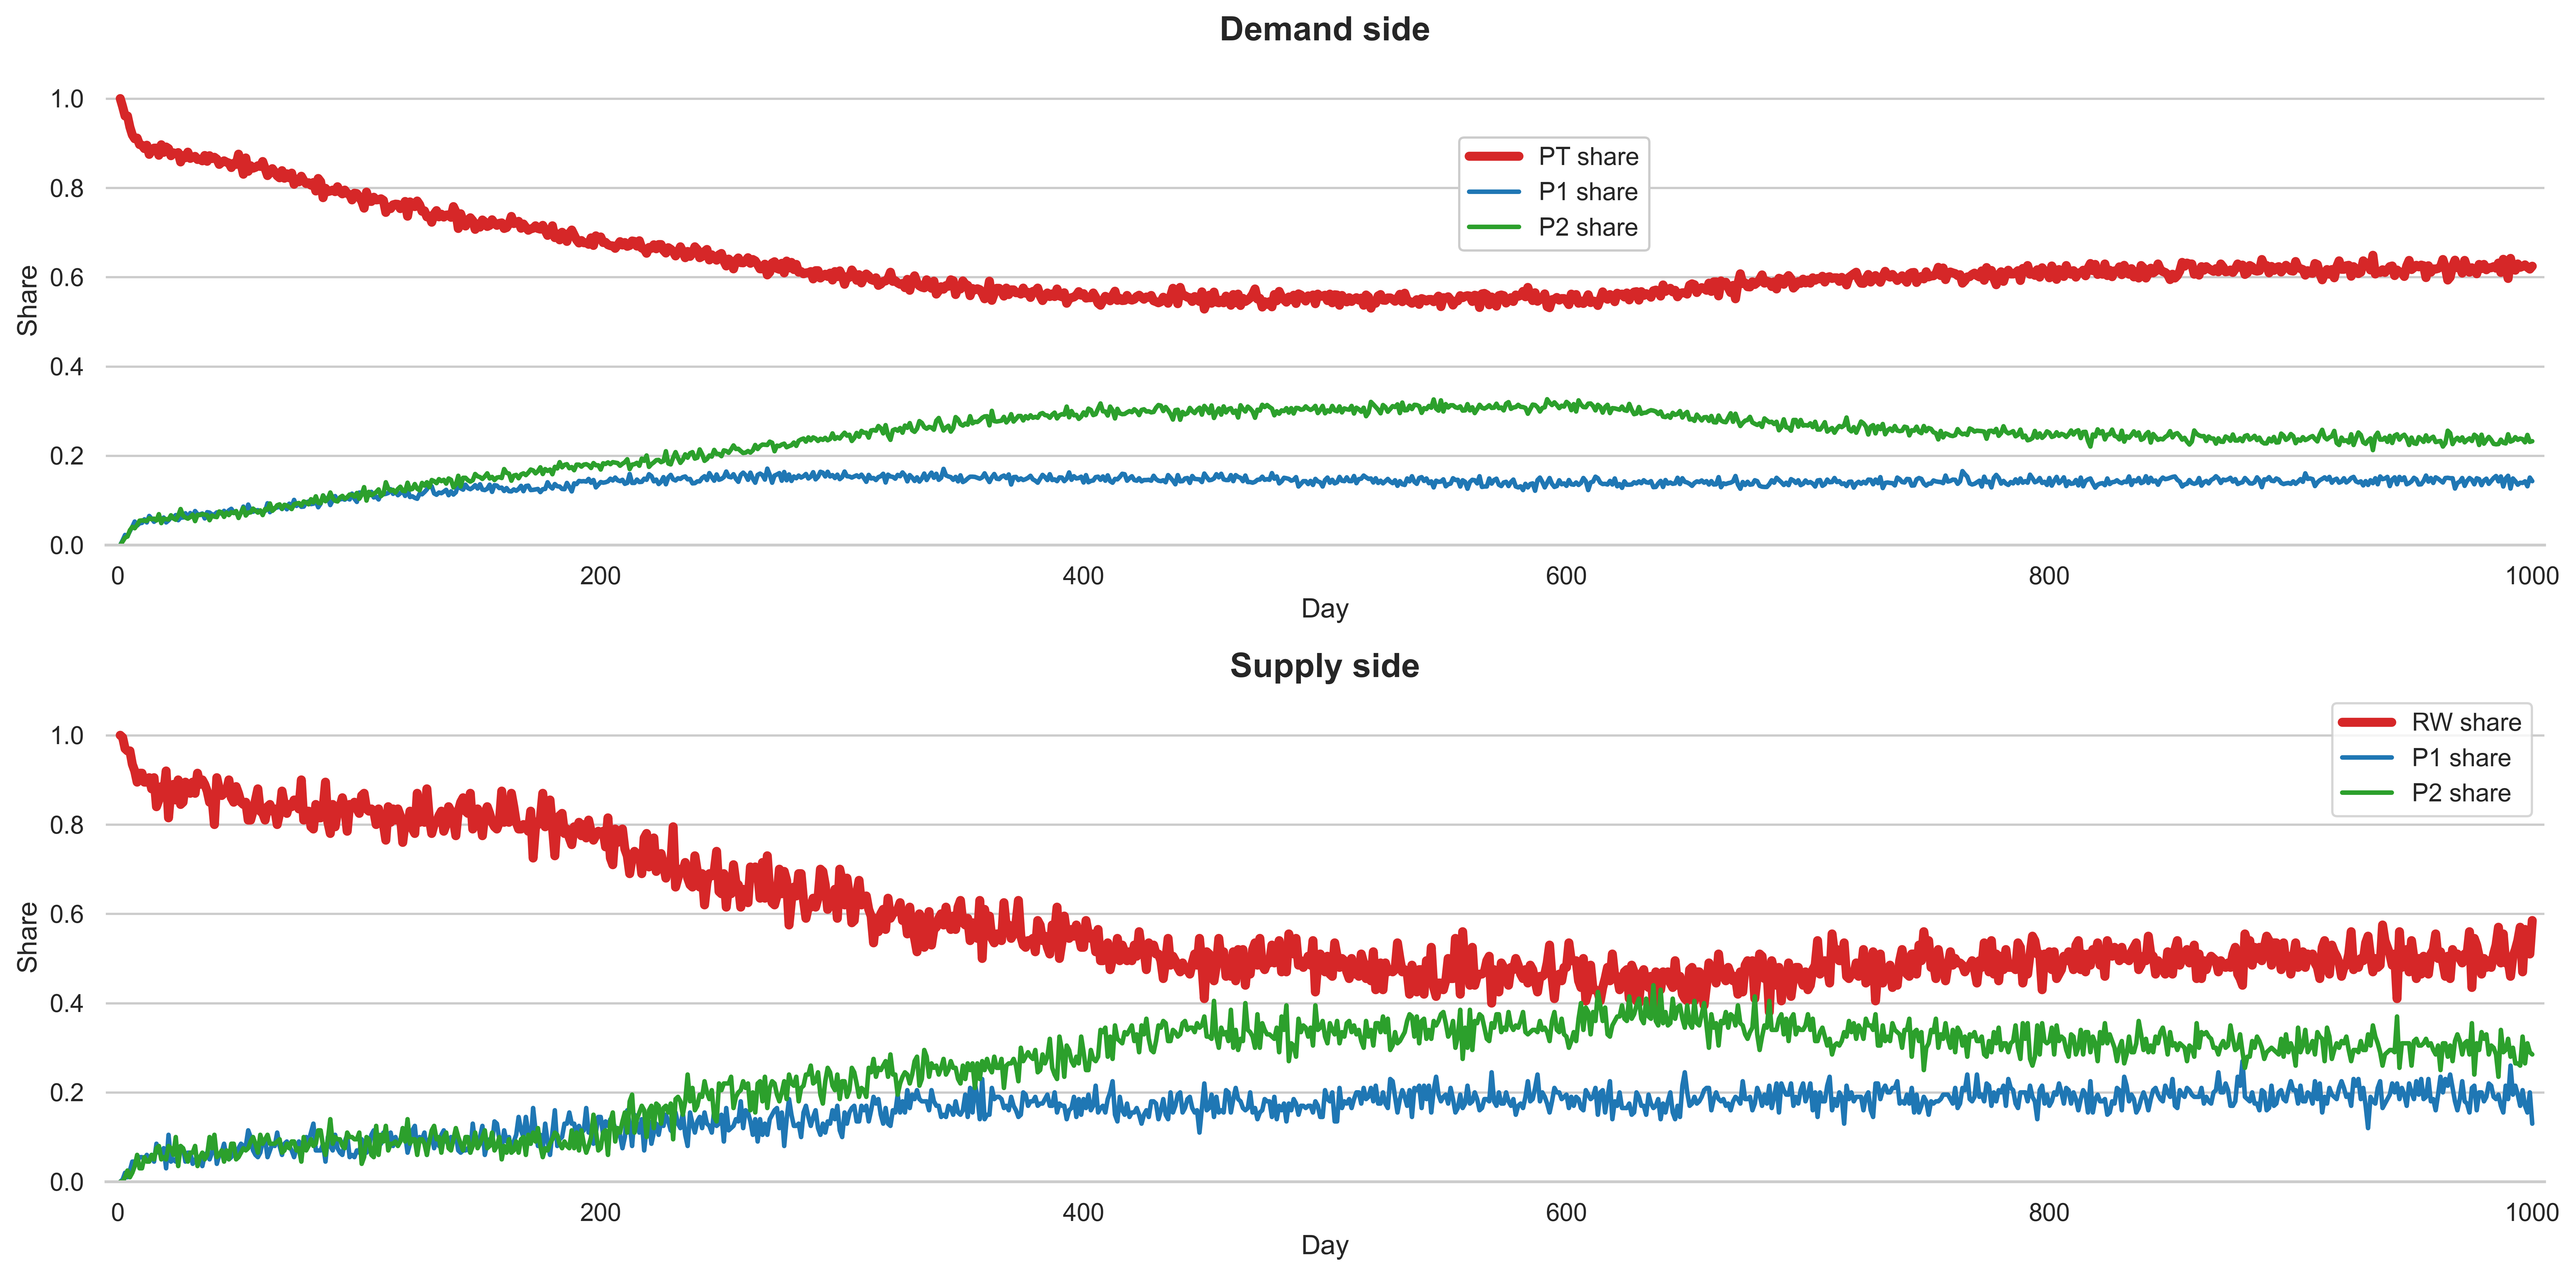

In [8]:
# with S-shaped curve nD=200 nP=2000 nV=200, with increased passenger sensitivity to changes in system
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
sns.despine(left=True)

# df_d

# sns.lineplot(x=df_d.index, y=1-(df_d.P1_OUT+df_d.P2_OUT), label = 'PT share', color='C3', lw=4, ax=ax[0])#, marker='o')
# sns.lineplot(x=df_d.index, y=df_d.P1_OUT, label = 'P1 share', color='C0', lw=2, ax=ax[0])#, marker='o')
# sns.lineplot(x=df_d.index, y=df_d.P2_OUT, label = 'P2 share', color='C2', lw=2, ax=ax[0])#, marker='o')

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    ypt= [] ; yp1=[]; yp2 = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            df = sim.res[d].pax_exp
            ypt.append(df.OUT.value_counts().get(True, 0)/params.nP)
            yp1.append(len(df[df.platform_id==1])/params.nP)
            yp2.append(len(df[df.platform_id==2])/params.nP)
        lx = [i for i in range(1,len(ypt)+1)]
        sns.lineplot(x=lx, y=ypt, label = 'PT share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
        sns.lineplot(x=lx, y=yp1, label = 'P1 share', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
        sns.lineplot(x=lx, y=yp2, label = 'P2 share', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            df = sim.res[d].veh_exp
            ypt.append(df.OUT.value_counts().get(True, 0)/params.nV)
            yp1.append(len(df[df.platform_id==1])/params.nV)
            yp2.append(len(df[df.platform_id==2])/params.nV)
        lx = [i for i in range(1,len(ypt)+1)]
        sns.lineplot(x=lx, y=ypt, label = 'RW share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
        sns.lineplot(x=lx, y=yp1, label = 'P1 share', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
        sns.lineplot(x=lx, y=yp2, label = 'P2 share', color='C2', lw=2, ax=ax[ax_n])#, marker='o')

    
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,1005))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.6))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

In [17]:
sim.competition_trajectory

[(1.0, 1.0),
 (1.0, 1.2),
 (1.2, 1.2),
 (1.2, 1.4),
 (1.4, 1.4),
 (1.4, 1.6),
 (1.6, 1.6),
 (1.6, 1.6),
 (1.6, 1.6),
 (1.6, 1.6)]

<AxesSubplot:>

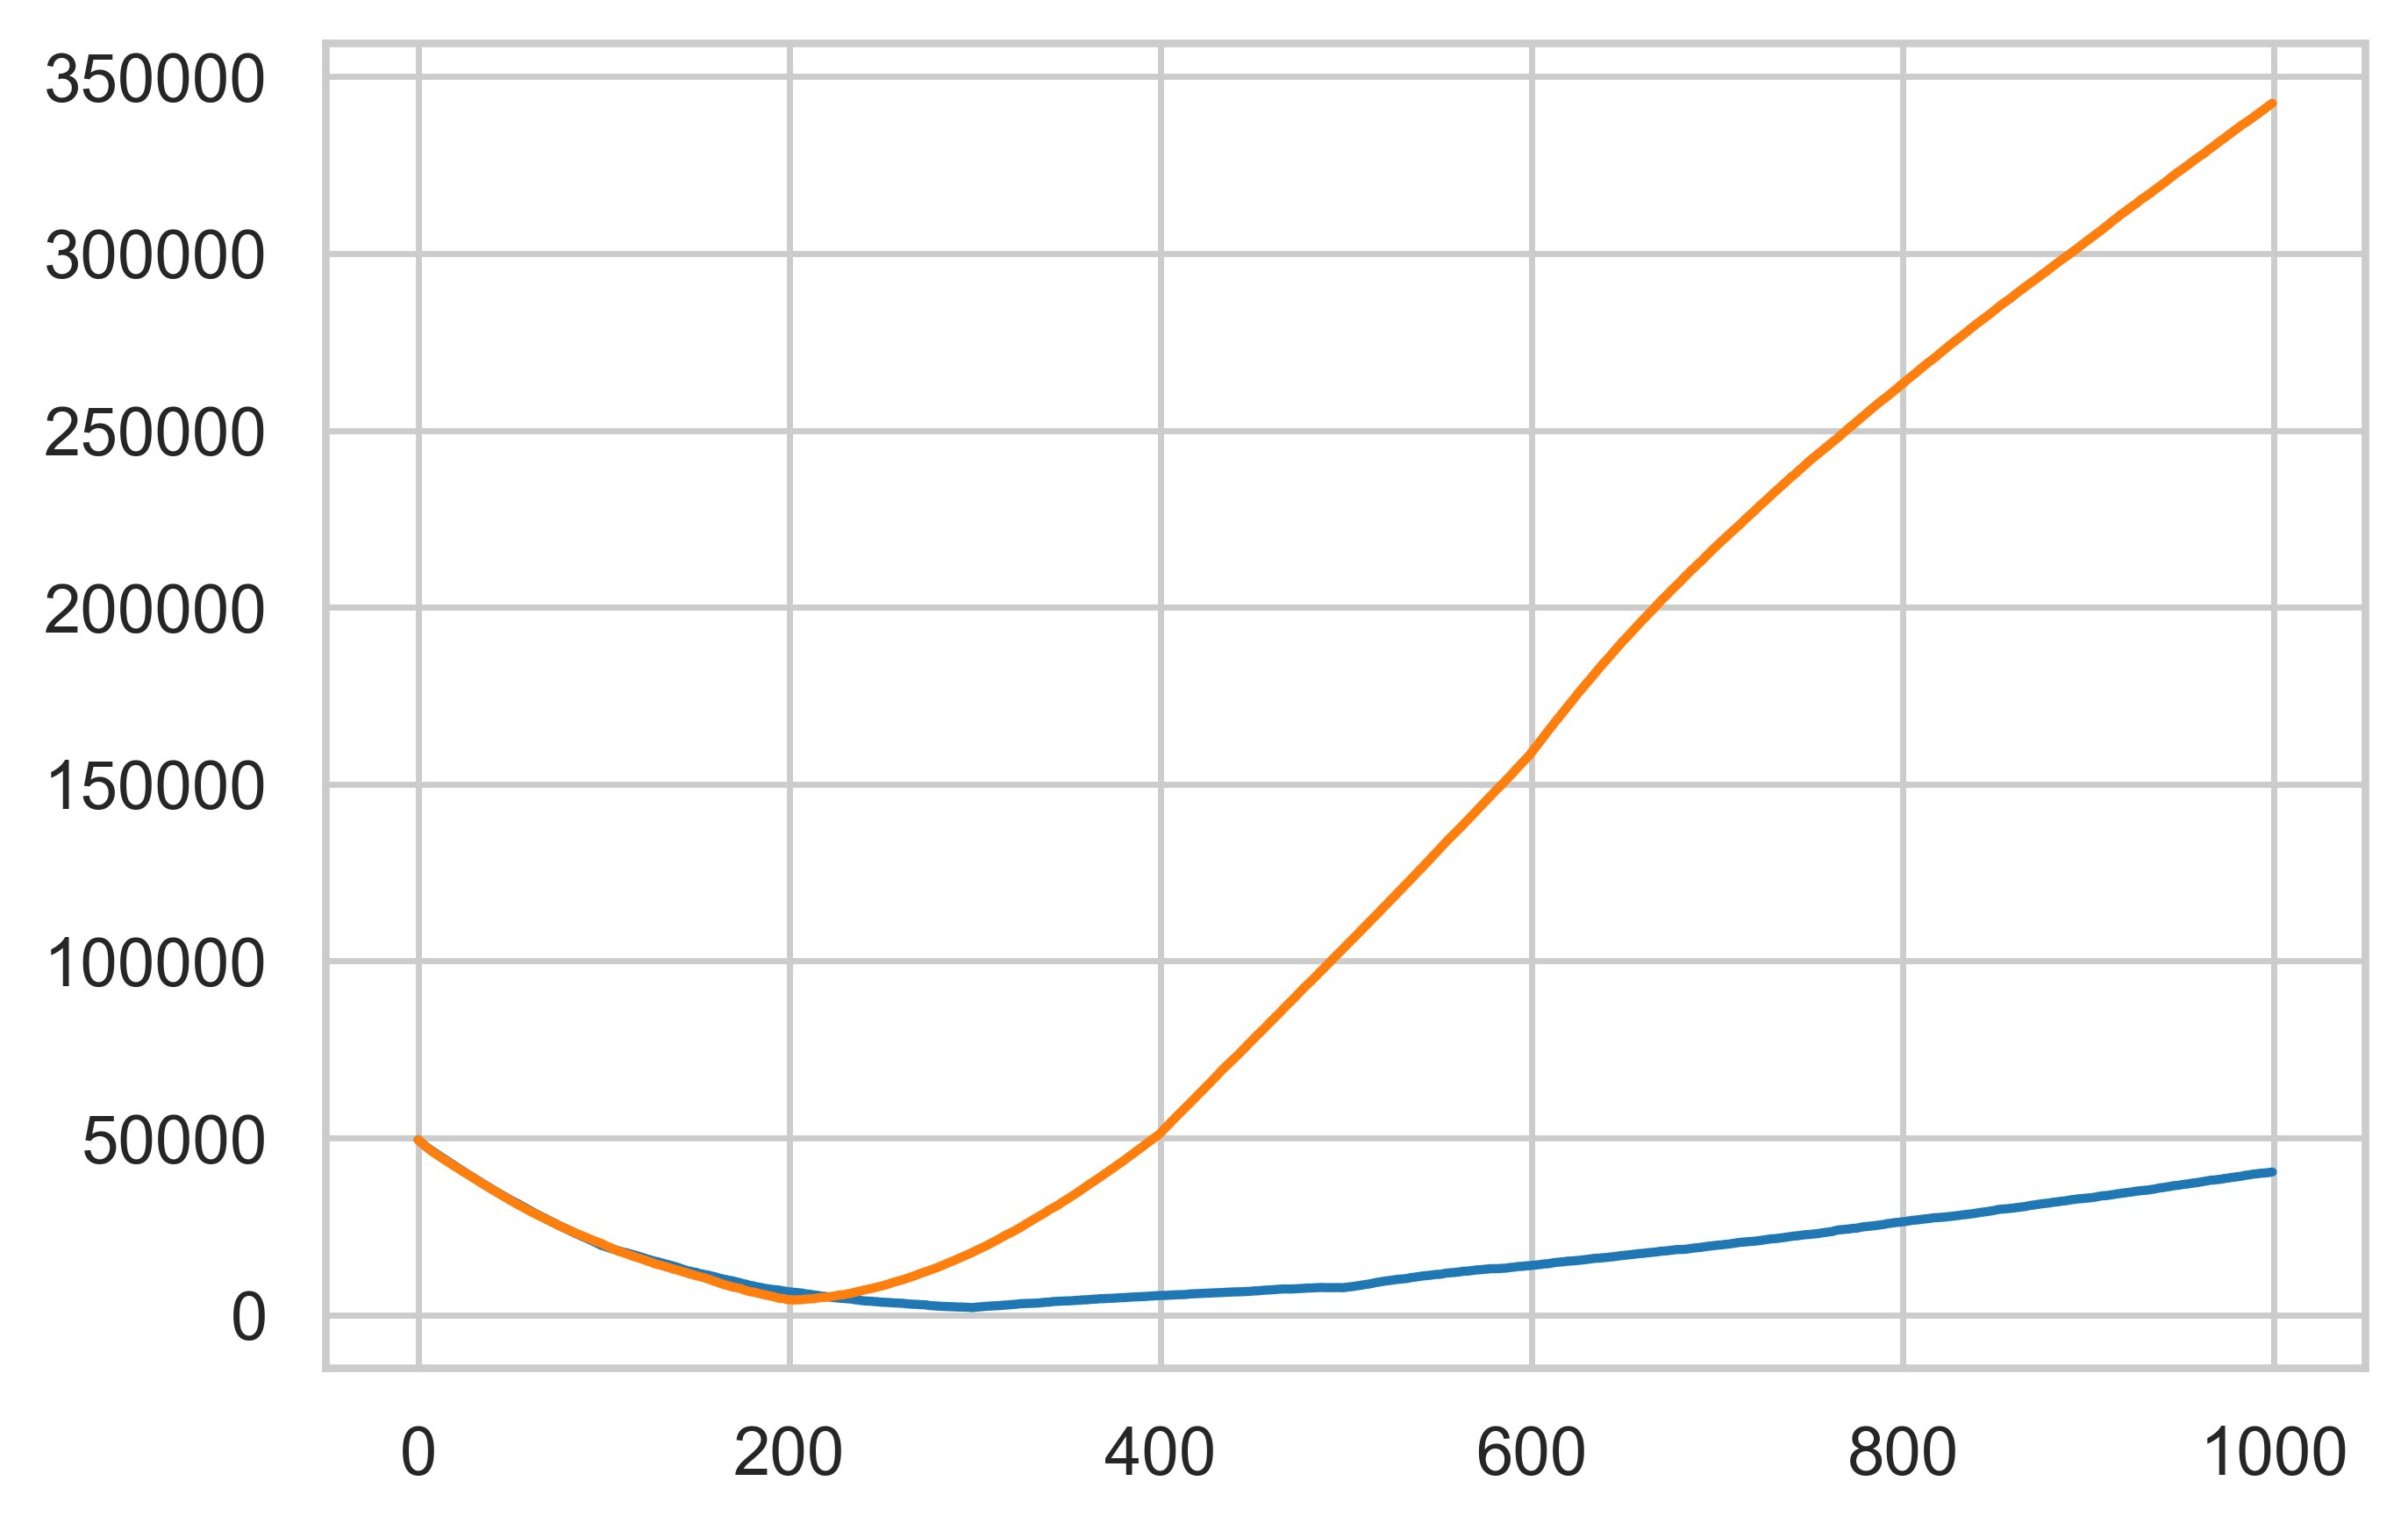

In [10]:
p1_rc = []
p2_rc = []
days = []

for d in range(1000):
    days.append(d)
    p1_rc.append(sim.res[d].platforms.P_remaining_capital[1])
    p2_rc.append(sim.res[d].platforms.P_remaining_capital[2])
    
    
sns.lineplot(x=days, y=p1_rc)
sns.lineplot(x=days, y=p2_rc)

In [18]:
sim.res[0].platforms.P_remaining_capital[1]

49500.0

In [14]:
def smooth(y,w=41,o=1,d=5):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

In [13]:
df = sim.res[999].pax_exp
ff = df[df.platform_id==1]
ff

P_U       PT_U  ACTUAL_WT     U_dif    OUT   mu   wu  \
pax                                                                
0    -12.465233 -10.056447  13.550000  0.239527  False  1.0  1.0   
1    -13.192061 -14.028102   0.116667 -0.059598  False  1.0  1.0   
15   -12.580614 -14.193247   0.450000 -0.113620  False  1.0  1.0   
26   -11.668947 -13.487007   3.533333 -0.134801  False  1.0  1.0   
33   -10.806331 -11.106069   7.116667 -0.026989  False  1.0  1.0   
...         ...        ...        ...       ...    ...  ...  ...   
1981 -23.718200 -15.662138  11.833333  0.514365  False  1.0  1.0   
1984  -9.316628 -10.815700   2.016667 -0.138601  False  1.0  1.0   
1989 -10.282339 -10.692714   3.333333 -0.038379  False  1.0  1.0   
1997  -9.944028 -10.274451   0.983333 -0.032160  False  1.0  1.0   
1998  -9.985722 -10.708116   2.366667 -0.067462  False  1.0  1.0   

      nDAYS_HAILED  nDAYS_TRY  P1_EXPERIENCE_U  ...  ACCEPTS_OFFER  \
pax                                             ...                  
0            745.0      761.0         0.983953  ...           15.0   
1            809.0      814.0         0.988751  ...           15.0   
15           732.0      739.0         0.990000  ...           15.0   
26           747.0      751.0         0.990000  ...           15.0   
33           760.0      764.0         0.990000  ...           15.0   
...            ...        ...              ...  ...            ...   
1981         200.0      208.0         0.010000  ...           15.0   
1984         766.0      769.0         0.990000  ...           15.0   
1989         681.0      689.0         0.990000  ...           15.0   
1997         683.0      683.0         0.990000  ...           15.0   
1998         753.0      755.0         0.990000  ...           15.0   

      REJECTS_OFFER  ARRIVES_AT_PICKUP  MEETS_DRIVER_AT_PICKUP  \
pax                                                              
0               0.0               20.0                   813.0   
1               0.0               20.0                     7.0   
15              0.0               20.0                    27.0   
26              0.0               20.0                   212.0   
33              0.0               20.0                   427.0   
...             ...                ...                     ...   
1981            0.0               20.0                   710.0   
1984            0.0               20.0                   121.0   
1989            0.0               20.0                   200.0   
1997            0.0               20.0                    59.0   
1998            0.0               20.0                   142.0   

      DEPARTS_FROM_PICKUP ARRIVES_AT_DROPOFF SETS_OFF_FOR_DEST  \
pax                                                              
0                    30.0              330.0              10.0   
1                    30.0              620.0              10.0   
15                   30.0              581.0              10.0   
26                   30.0              475.0              10.0   
33                   30.0              363.0              10.0   
...                   ...                ...               ...   
1981                 30.0              956.0              10.0   
1984                 30.0              380.0              10.0   
1989                 30.0              406.0              10.0   
1997                 30.0              432.0              10.0   
1998                 30.0              408.0              10.0   

      ARRIVES_AT_DEST  PREFERS_OTHER_SERVICE  LOSES_PATIENCE  
pax                                                           
0                 0.0                    0.0             0.0  
1                 0.0                    0.0             0.0  
15                0.0                    0.0             0.0  
26                0.0                    0.0             0.0  
33                0.0                    0.0             0.0  
...               ...                    ...             

In [15]:
ff[ff.PT_U<ff.P_U]

P_U       PT_U  ACTUAL_WT     U_dif    OUT   mu   wu  \
pax                                                                
1    -13.192061 -14.028102   0.116667 -0.059598  False  1.0  1.0   
15   -12.580614 -14.193247   0.450000 -0.113620  False  1.0  1.0   
26   -11.668947 -13.487007   3.533333 -0.134801  False  1.0  1.0   
33   -10.806331 -11.106069   7.116667 -0.026989  False  1.0  1.0   
36   -12.308786 -12.883964   0.133333 -0.044643  False  1.0  1.0   
...         ...        ...        ...       ...    ...  ...  ...   
1977  -9.059892  -9.582334   3.266667 -0.054521  False  1.0  1.0   
1984  -9.316628 -10.815700   2.016667 -0.138601  False  1.0  1.0   
1989 -10.282339 -10.692714   3.333333 -0.038379  False  1.0  1.0   
1997  -9.944028 -10.274451   0.983333 -0.032160  False  1.0  1.0   
1998  -9.985722 -10.708116   2.366667 -0.067462  False  1.0  1.0   

      nDAYS_HAILED  nDAYS_TRY  P1_EXPERIENCE_U  ...  ACCEPTS_OFFER  \
pax                                             ...                  
1            809.0      814.0         0.988751  ...           15.0   
15           732.0      739.0         0.990000  ...           15.0   
26           747.0      751.0         0.990000  ...           15.0   
33           760.0      764.0         0.990000  ...           15.0   
36           712.0      714.0         0.990000  ...           15.0   
...            ...        ...              ...  ...            ...   
1977         704.0      707.0         0.990000  ...           15.0   
1984         766.0      769.0         0.990000  ...           15.0   
1989         681.0      689.0         0.990000  ...           15.0   
1997         683.0      683.0         0.990000  ...           15.0   
1998         753.0      755.0         0.990000  ...           15.0   

      REJECTS_OFFER  ARRIVES_AT_PICKUP  MEETS_DRIVER_AT_PICKUP  \
pax                                                              
1               0.0               20.0                     7.0   
15              0.0               20.0                    27.0   
26              0.0               20.0                   212.0   
33              0.0               20.0                   427.0   
36              0.0               20.0                     8.0   
...             ...                ...                     ...   
1977            0.0               20.0                   196.0   
1984            0.0               20.0                   121.0   
1989            0.0               20.0                   200.0   
1997            0.0               20.0                    59.0   
1998            0.0               20.0                   142.0   

      DEPARTS_FROM_PICKUP ARRIVES_AT_DROPOFF SETS_OFF_FOR_DEST  \
pax                                                              
1                    30.0              620.0              10.0   
15                   30.0              581.0              10.0   
26                   30.0              475.0              10.0   
33                   30.0              363.0              10.0   
36                   30.0              573.0              10.0   
...                   ...                ...               ...   
1977                 30.0              343.0              10.0   
1984                 30.0              380.0              10.0   
1989                 30.0              406.0              10.0   
1997                 30.0              432.0              10.0   
1998                 30.0              408.0              10.0   

      ARRIVES_AT_DEST  PREFERS_OTHER_SERVICE  LOSES_PATIENCE  
pax                                                           
1                 0.0                    0.0             0.0  
15                0.0                    0.0             0.0  
26                0.0                    0.0             0.0  
33                0.0                    0.0             0.0  
36                0.0                    0.0             0.0  
...               ...                    ...             

In [27]:
df = sim.res[998].veh_exp
df[df.platform_id==1].ACTUAL_INC.mean()

45.37350500000001

In [21]:
params.d2d.res_wage

44.64

In [25]:
def smooth(y,w=41,o=1,d=5):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

In [17]:
sim.res[1].platforms

P_revenue P_daily_profit P_remaining_capital
platform_id                                             
1             19.4252      -480.5748          49019.4252
2              18.187       -481.813           49018.187

<AxesSubplot:>

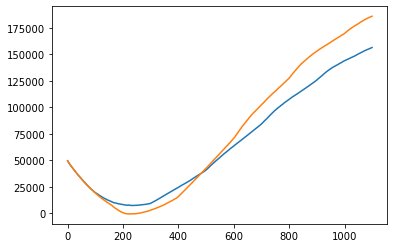

In [20]:
p1 = []
p2 = []
days = []

for d in range(1100):
    days.append(d)
    
    p1df = sim.res[d].platforms
    p1.append(p1df.P_remaining_capital[1])
    
    p2df = sim.res[d].platforms
    p2.append(p2df.P_remaining_capital[2])
    
sns.lineplot(x=days, y=p1)
sns.lineplot(x=days, y=p2)

In [ ]:
p1 = []
p2 = []
days = []

for d in range(1000):
    days.append(d)
    
    p1df = sim.res[d].pax_exp
    p1.append(p1df[p1df.platform_id==1].ACTUAL_WT.mean())
    
    p2df = sim.res[d].pax_exp
    p2.append(p2df[p1df.platform_id==2].ACTUAL_WT.mean())
    
sns.lineplot(x=days, y=smooth(p1))
sns.lineplot(x=days, y=smooth(p2))

In [ ]:
sim.res[d].pax_exp

<AxesSubplot:>

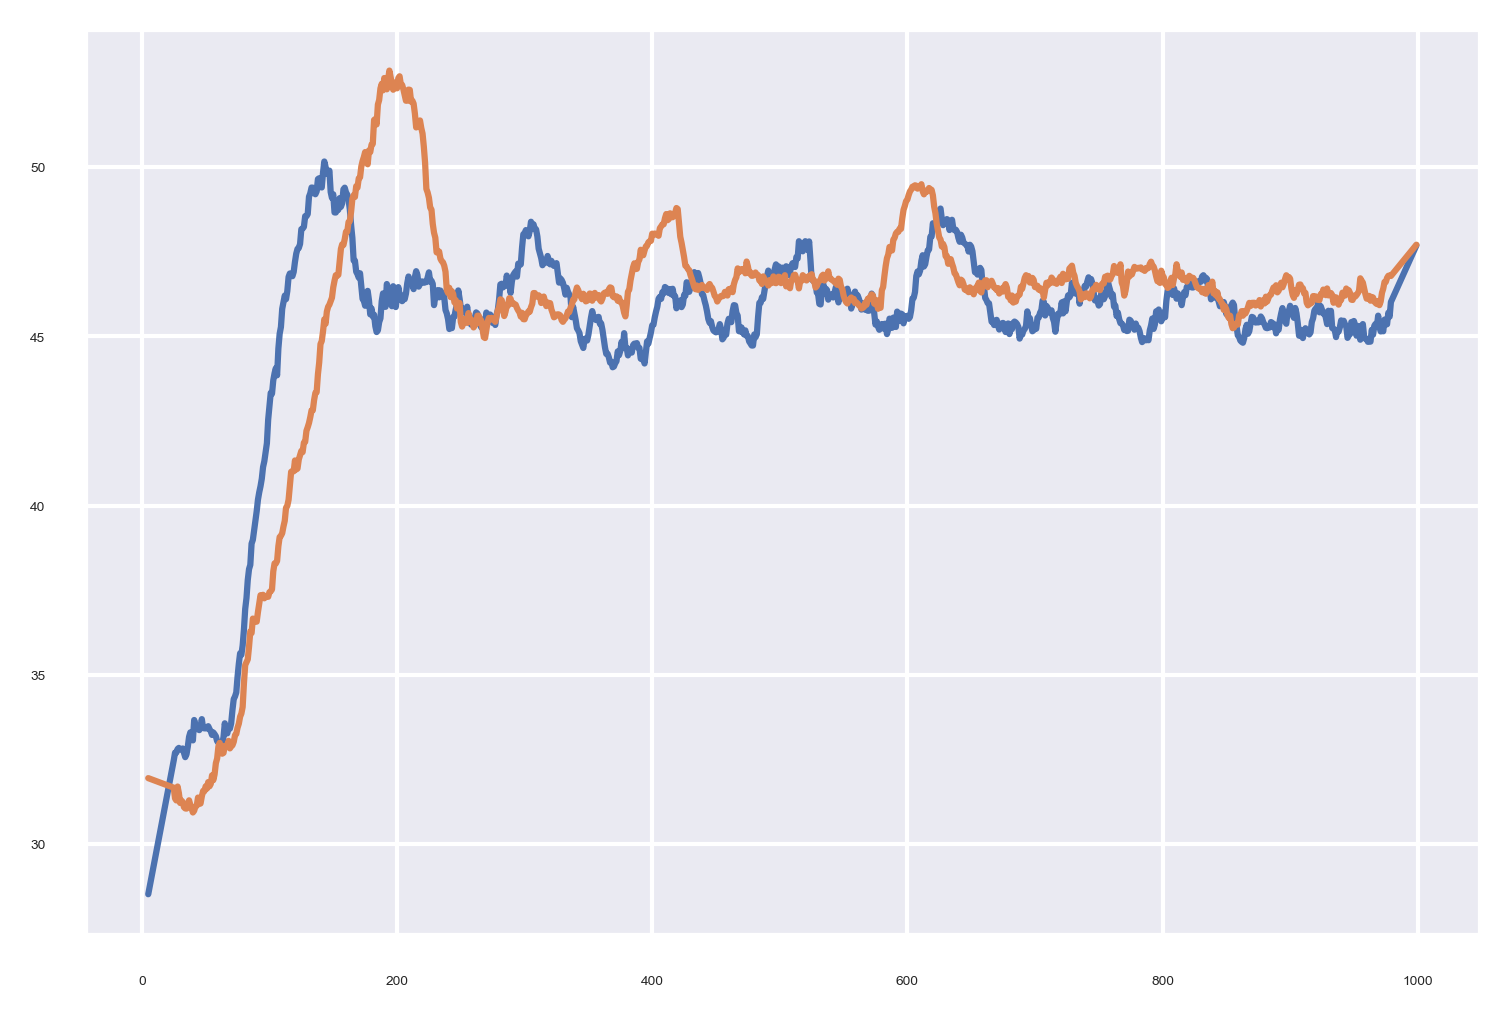

In [26]:
p1 = []
p2 = []
days = []

for d in range(1000):
    days.append(d)
    
    p1df = sim.res[d].veh_exp
    p1.append(p1df[p1df.platform_id==1].ACTUAL_INC.mean())
    
    p2df = sim.res[d].veh_exp
    p2.append(p2df[p1df.platform_id==2].ACTUAL_INC.mean())
    
sns.lineplot(x=days, y=smooth(p1))
sns.lineplot(x=days, y=smooth(p2))

<AxesSubplot:>

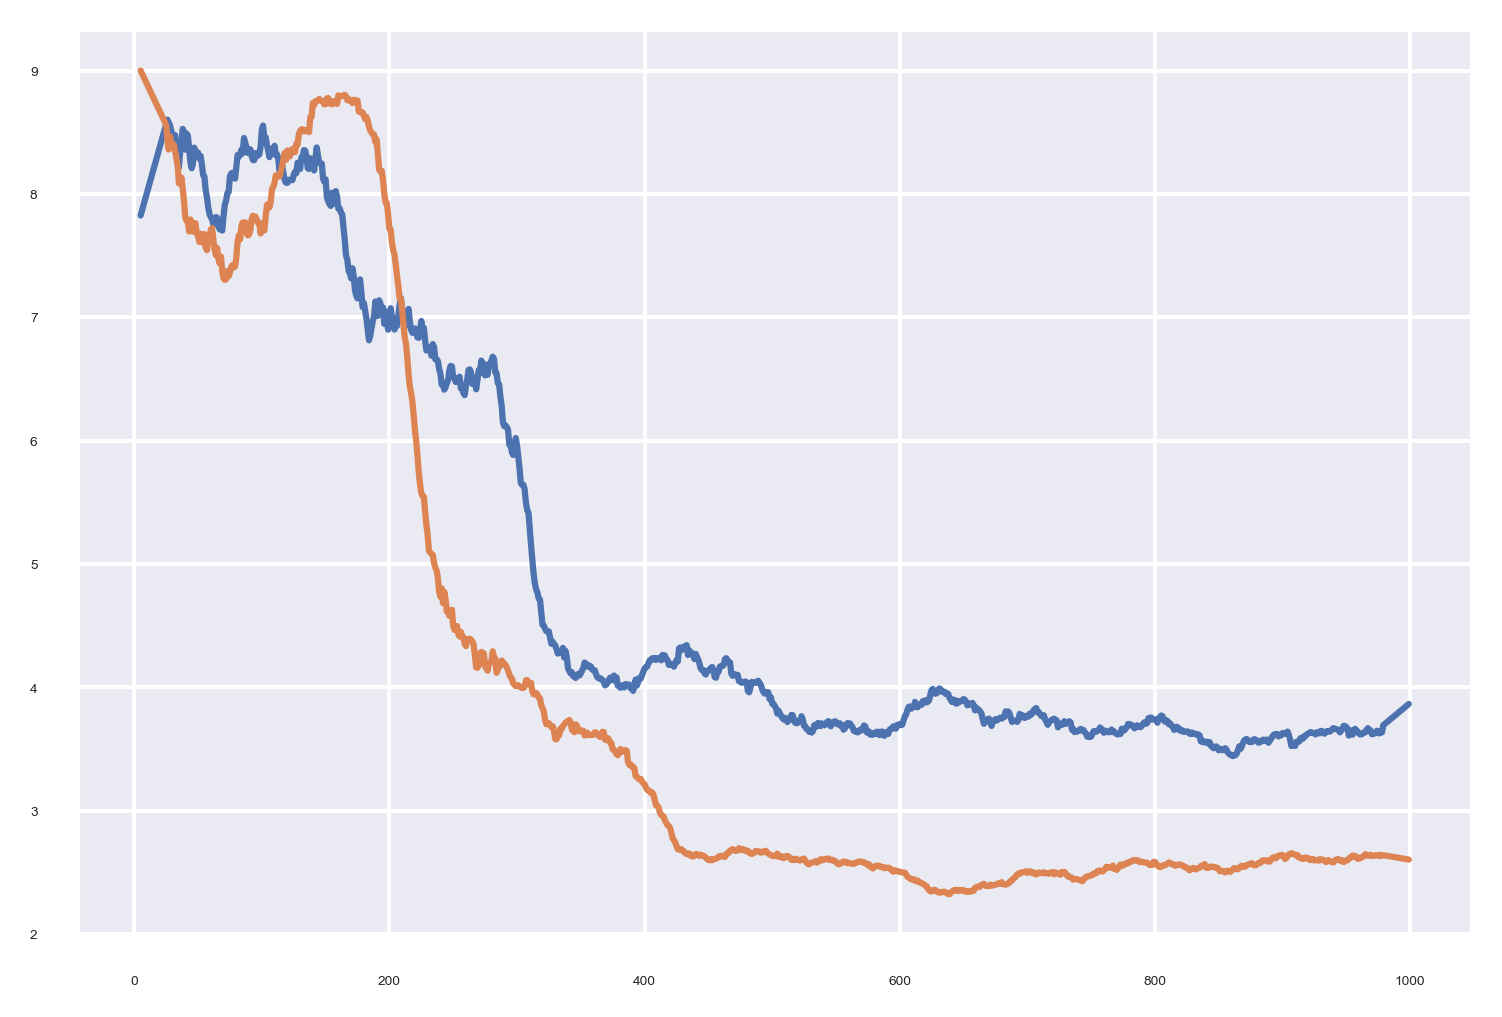

In [32]:
p1 = []
p2 = []
days = []

for d in range(1000):
    days.append(d)
    
    p1df = sim.res[d].pax_exp
    p1.append(p1df[p1df.platform_id==1].ACTUAL_WT.mean())
    
    p2df = sim.res[d].pax_exp
    p2.append(p2df[p1df.platform_id==2].ACTUAL_WT.mean())
    
sns.lineplot(x=days, y=smooth(p1))
sns.lineplot(x=days, y=smooth(p2))